# CASE: Controle de Inadimplência em Operações de Crédito

# Resumo

# Introdução

Uma fintech de Crédito iniciou sua operação de concessão de empréstimo pessoal e acompanhou a performance de pagamento de 1.000 clientes após 1 ano. Com base dessa amostra, pediu para a área de Análise de Dados verificar quais os fatores de risco dos clientes de forma a conseguir aprovar mais contratos com a menor inadimplência possível.

Com base nessas informações, pede-se:

***Quais fatores de risco estão mais associados a inadimplência? Com isso, o que a fintech deveria mudar de forma a minimizar a inadimplência?***


# Importação das Bibliotecas

In [2]:
# Pacote de Manipulação de Dados
import pandas as pd
import numpy as np

# Pacote Gráfico
import seaborn as sns
import matplotlib.pyplot as plt

# Pacotes de Modelagem
import statsmodels as sms
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, RocCurveDisplay
)

# Pacote de Funções Auxiliares
import utils.aux_func as af
from utils.paths import DATA_RAW, DATA_PROCESSED

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Params
plt.rcParams['figure.dpi'] = 400
pd.set_option('display.max_columns', None)


# Importação da Base

In [3]:
df = pd.read_excel(DATA_RAW / "Base_Inadimplencia.xlsx", sheet_name="Base")
df.head(10)

Idade Sexo   Escolaridade Tipo_Moradia Saldo_Investimento  \
0     67    M      Graduacao      Propria   Sem investimento   
1     22    H      Graduacao      Propria              Pouco   
2     49    M  Pos Graduacao      Propria              Pouco   
3     45    M      Graduacao     De favor              Pouco   
4     53    M      Graduacao     De favor              Pouco   
5     35    M  Pos Graduacao     De favor   Sem investimento   
6     53    M      Graduacao      Propria               Alto   
7     35    M   Ensino Medio      Alugada              Pouco   
8     61    M  Pos Graduacao      Propria               Alto   
9     28    M   Ensino Medio      Propria              Pouco   

  Saldo_Conta_Corrente  Valor_Emprestimo  Duracao_Emprestimo  Inadimplencia  
0                Pouco              1169                   6              0  
1             Moderado              5951                  48              1  
2            Sem conta              2096                  12              0  
3                Pouco              7882                  42              0  
4                Pouco              4870                  24              1  
5            Sem conta              9055                  36              0  
6            Sem conta              2835                  24              0  
7             Moderado              6948                  36              0  
8            Sem conta              3059                  12              0  
9             Moderado              5234                  30              1

In [4]:
df.shape

(1000, 9)

# Dicionário de Dados (Metadados)


| Variável               | Tipo               | Faixa / Categorias                                                                 | Descrição                                                                 |
|------------------------|--------------------|--------------------------------------------------------------------------------------|----------------------------------------------------------------------------|
| **Idade**              | Numérica (inteiro) | Geralmente entre 18 e 80 anos (dependendo do dataset)                                | Idade do cliente no momento da solicitação do empréstimo.                 |
| **Sexo**               | Categórica         | H (Homem), M (Mulher)                                                                | Sexo informado pelo cliente.                                              |
| **Escolaridade**       | Categórica ordinal | Médio, Graduação, Pós-Graduação                                                      | Nível educacional do cliente.                                             |
| **Tipo_Moradia**       | Categórica         | Mora de favor, Aluguel, Casa própria                                                 | Situação habitacional do cliente.                                         |
| **Saldo_Investimento** | Categórica ordinal | Faixas de saldo (ex.: Sem saldo, Baixo, Médio, Alto)                                 | Indica se o cliente possui investimentos em outro banco e a faixa de saldo. |
| **Saldo_Conta_Corrente** | Categórica ordinal | Faixas de saldo (ex.: Sem saldo, Baixo, Médio, Alto)                                 | Indica se possui conta corrente em outro banco e sua faixa de saldo.       |
| **Valor_Emprestimo**   | Numérica (contínua) | Valores monetários (ex.: RS 500 a RS 50.000, conforme dataset)                        | Valor solicitado no empréstimo pessoal.                                   |
| **Duracao_Emprestimo** | Numérica (inteiro) | Em meses (ex.: 6 a 60 meses)                                                          | Prazo do empréstimo em meses.                                             |
| **Inadimplencia**      | Binária            | 0 = Não inadimplente, 1 = Inadimplente                                               | Variável alvo que indica ocorrência de inadimplência após o empréstimo.   |


# Removendo Feature `Sexo` (Questões Éticas)

In [5]:
df.drop(columns=['Sexo'], inplace=True)

# 1. Sanity Check

## 1.1 Valores Faltantes (Missing Values)

In [6]:
df.isnull().sum()

Idade                   0
Escolaridade            0
Tipo_Moradia            0
Saldo_Investimento      0
Saldo_Conta_Corrente    0
Valor_Emprestimo        0
Duracao_Emprestimo      0
Inadimplencia           0
dtype: int64

## 1.2 Valores Inconsistentes

In [7]:
df.describe()

Idade  Valor_Emprestimo  Duracao_Emprestimo  Inadimplencia
count  1000.000000       1000.000000         1000.000000    1000.000000
mean     35.546000       3271.258000           20.903000       0.300000
std      11.375469       2822.736876           12.058814       0.458487
min      19.000000        250.000000            4.000000       0.000000
25%      27.000000       1365.500000           12.000000       0.000000
50%      33.000000       2319.500000           18.000000       0.000000
75%      42.000000       3972.250000           24.000000       1.000000
max      75.000000      18424.000000           72.000000       1.000000

In [8]:
# Itera por todas as colunas categóricas (tipo object ou category)
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"\nColuna: {col}")
    print(df[col].unique())


Coluna: Escolaridade
<ArrowStringArray>
['Graduacao', 'Pos Graduacao', 'Ensino Medio']
Length: 3, dtype: str

Coluna: Tipo_Moradia
<ArrowStringArray>
['Propria', 'De favor', 'Alugada']
Length: 3, dtype: str

Coluna: Saldo_Investimento
<ArrowStringArray>
['Sem investimento', 'Pouco', 'Alto', 'Moderado']
Length: 4, dtype: str

Coluna: Saldo_Conta_Corrente
<ArrowStringArray>
['Pouco', 'Moderado', 'Sem conta', 'Alto']
Length: 4, dtype: str


In [9]:
df.nunique()

Idade                    53
Escolaridade              3
Tipo_Moradia              3
Saldo_Investimento        4
Saldo_Conta_Corrente      4
Valor_Emprestimo        921
Duracao_Emprestimo       33
Inadimplencia             2
dtype: int64

## 1.3 Valores Duplicados

In [10]:
df.duplicated().sum()

np.int64(0)

## 1.4 Tipagem de Dados

In [11]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Idade                 1000 non-null   int64
 1   Escolaridade          1000 non-null   str  
 2   Tipo_Moradia          1000 non-null   str  
 3   Saldo_Investimento    1000 non-null   str  
 4   Saldo_Conta_Corrente  1000 non-null   str  
 5   Valor_Emprestimo      1000 non-null   int64
 6   Duracao_Emprestimo    1000 non-null   int64
 7   Inadimplencia         1000 non-null   int64
dtypes: int64(4), str(4)
memory usage: 93.7 KB


In [12]:
target = 'Inadimplencia'
num_vars = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != target]
cat_vars = [col for col in df.columns if (df[col].dtype == 'object' or str(df[col].dtype) == 'category' or df[col].dtype == 'str') and col != target]

In [13]:
num_vars

['Idade', 'Valor_Emprestimo', 'Duracao_Emprestimo']

In [14]:
cat_vars

['Escolaridade', 'Tipo_Moradia', 'Saldo_Investimento', 'Saldo_Conta_Corrente']

## 1.5 Análise de Outliers

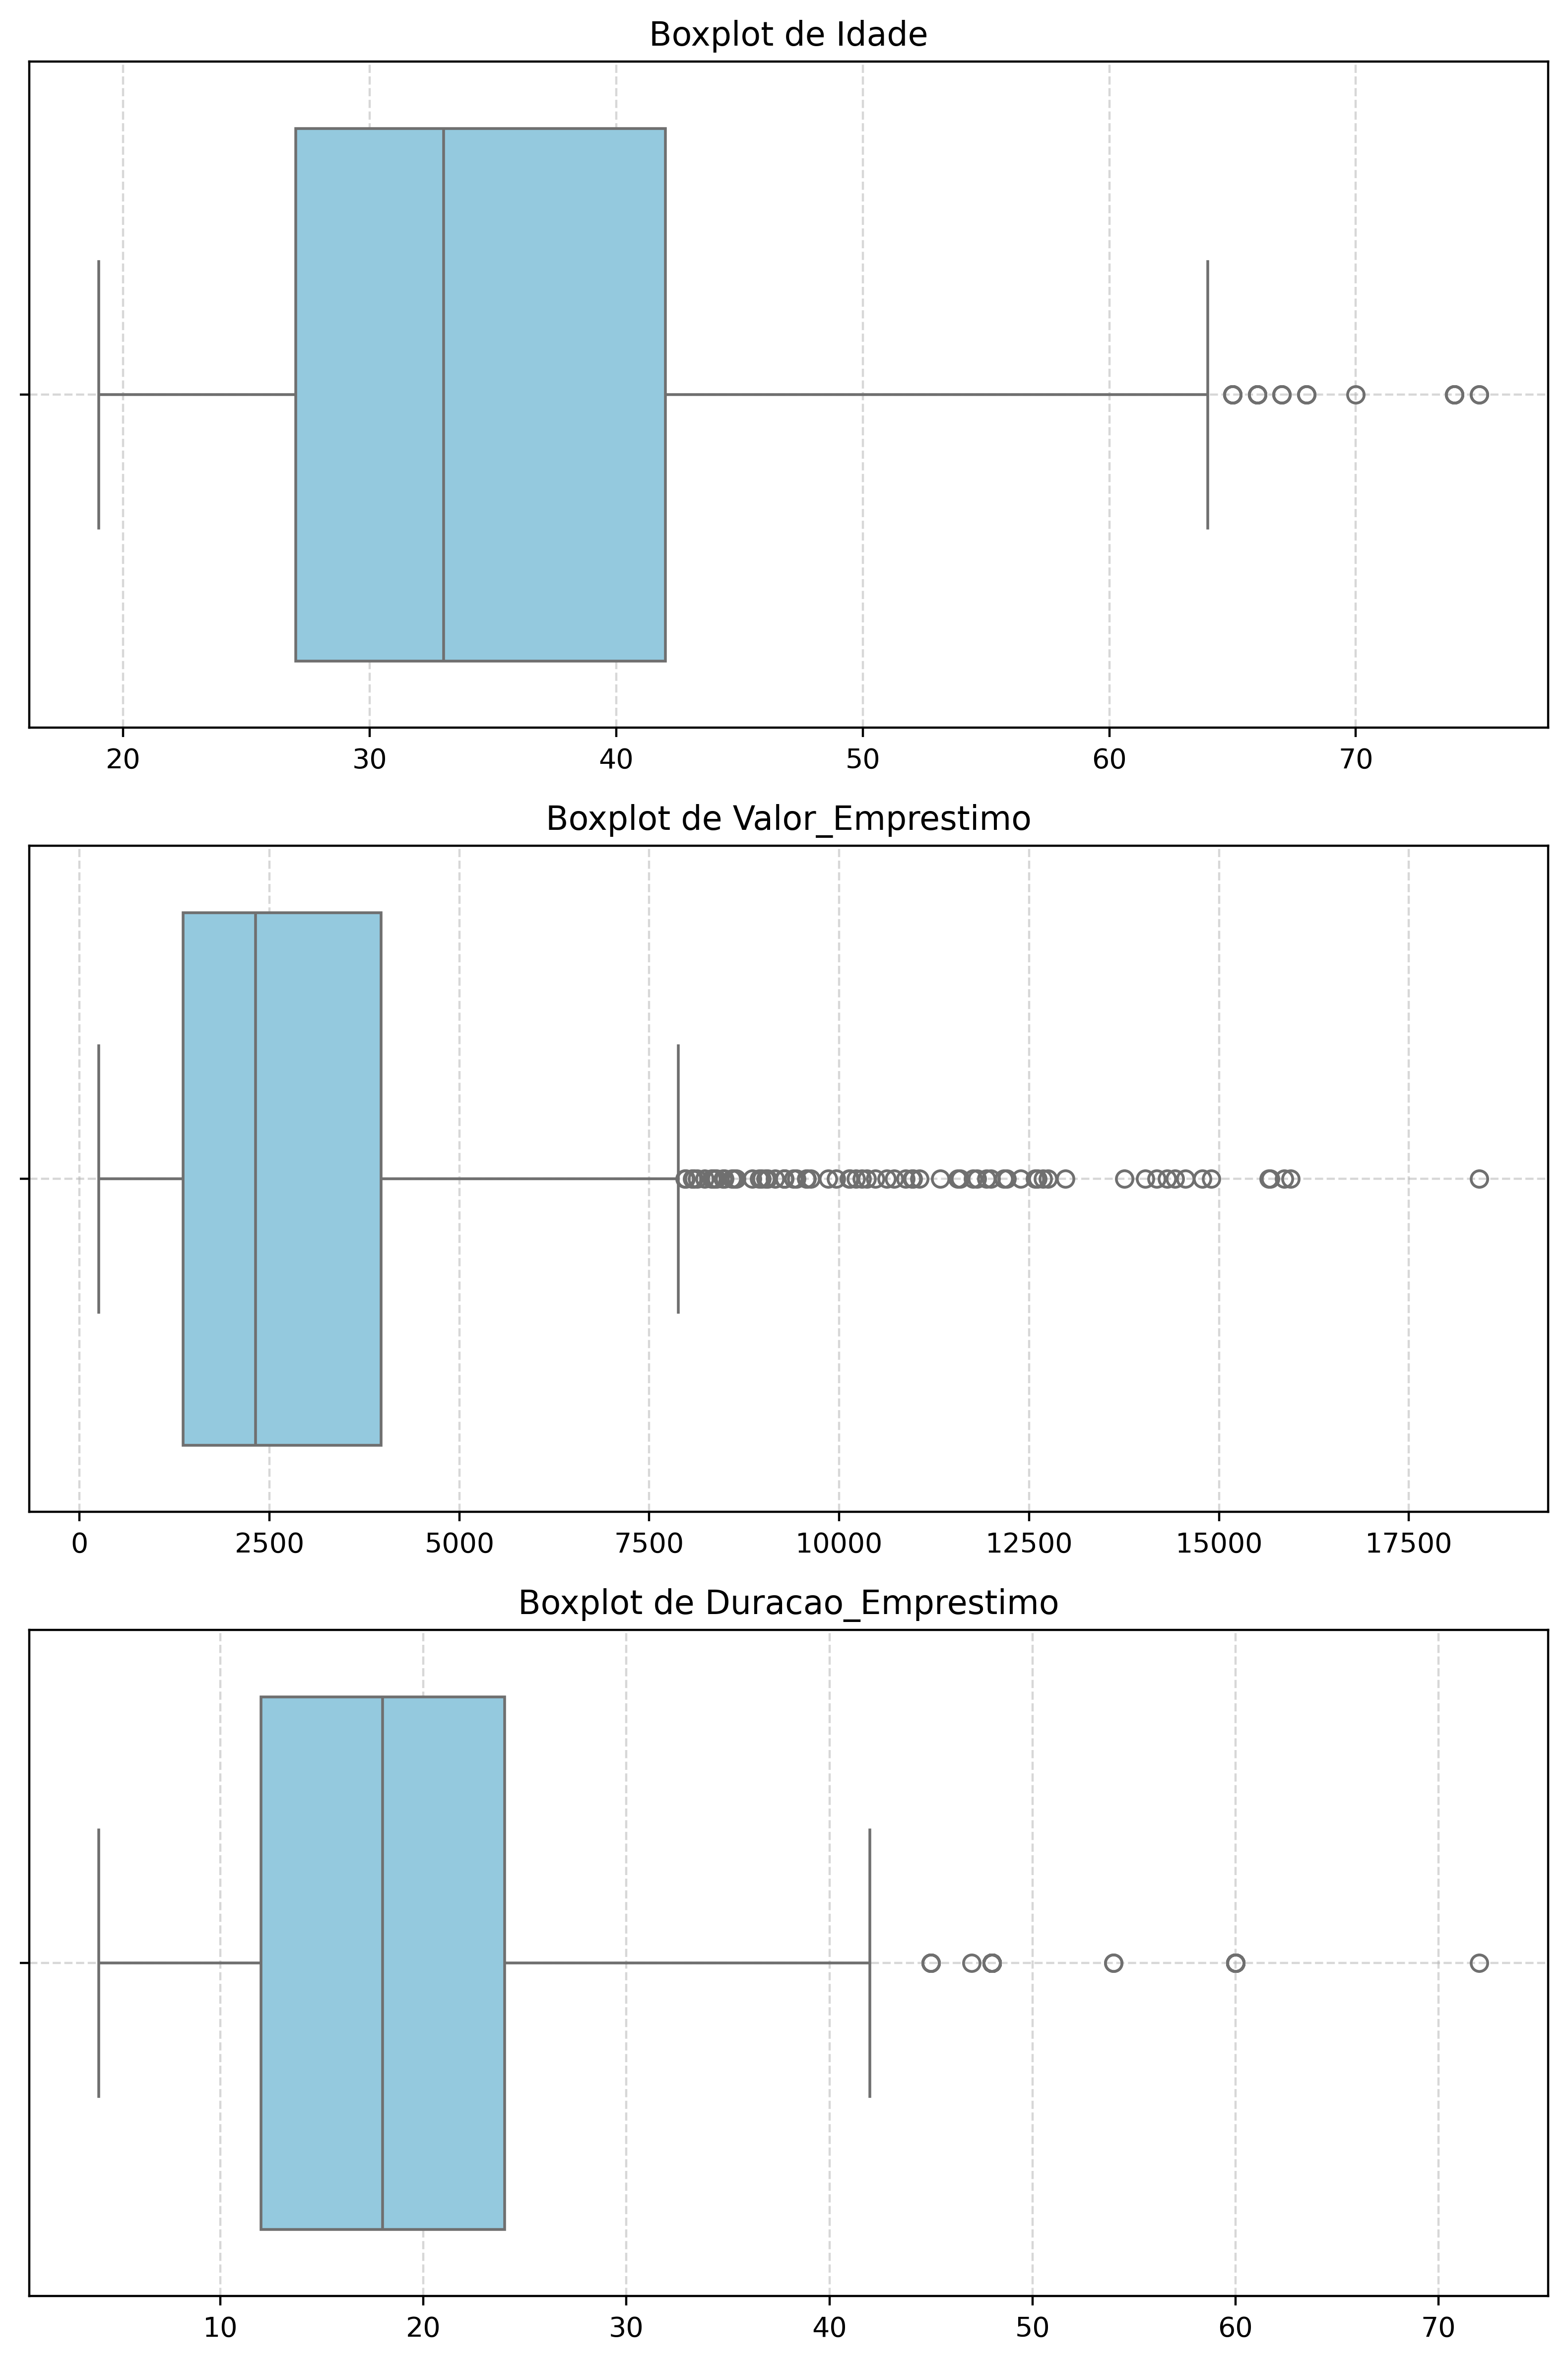

In [15]:
# Boxplots das variáveis quantitativas
## Cria o número de subplots com base na quantidade de variáveis numéricas
fig, axes = plt.subplots(nrows=len(num_vars), ncols=1, figsize=(8, 4 * len(num_vars)))

## Caso haja apenas uma variável, 'axes' não é uma lista — ajustamos isso
if len(num_vars) == 1:
    axes = [axes]

## Itera sobre as variáveis numéricas e plota cada boxplot em seu respectivo eixo
for i, col in enumerate(num_vars):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot de {col}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [16]:
# percentual de Outliers
outlier_stats = af.perc_outliers(df, num_vars)
display(outlier_stats)

Variável  %_Outliers
0    Valor_Emprestimo         7.2
1  Duracao_Emprestimo         7.0
2               Idade         2.3

# 2. Análise Exploratória dos Dados (AED)

## 2.1 Análise Univariada

### 2.1.1 Medidas Resumo - Análise Descritiva

In [17]:
df.describe()

Idade  Valor_Emprestimo  Duracao_Emprestimo  Inadimplencia
count  1000.000000       1000.000000         1000.000000    1000.000000
mean     35.546000       3271.258000           20.903000       0.300000
std      11.375469       2822.736876           12.058814       0.458487
min      19.000000        250.000000            4.000000       0.000000
25%      27.000000       1365.500000           12.000000       0.000000
50%      33.000000       2319.500000           18.000000       0.000000
75%      42.000000       3972.250000           24.000000       1.000000
max      75.000000      18424.000000           72.000000       1.000000

### 2.1.2 Análise de Normalidade - Histogramas + QQPlots + Testes Shapiro-Wilk (num_vars)

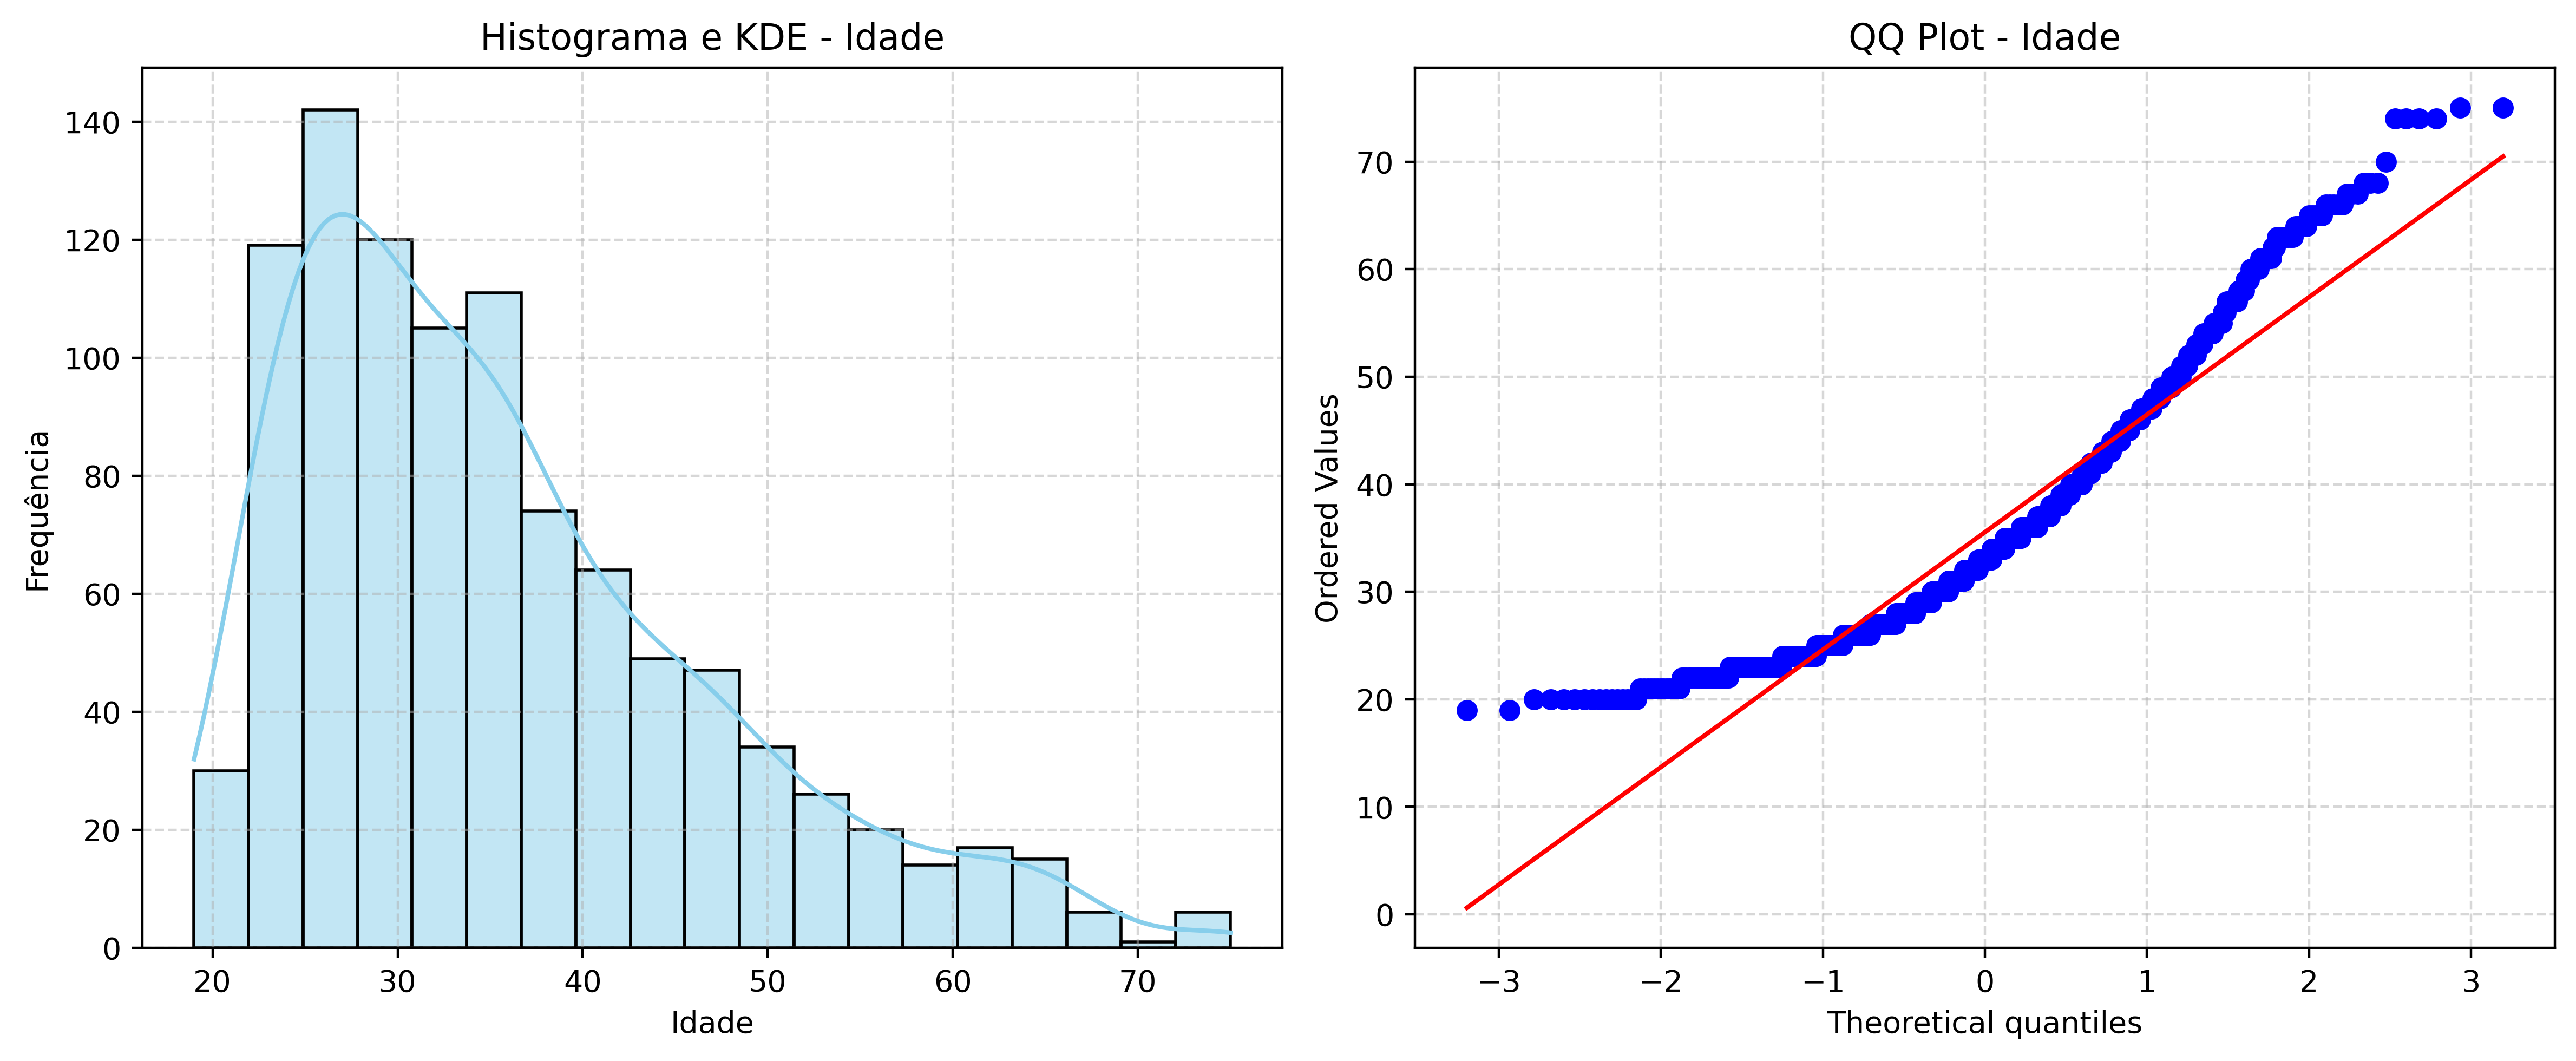

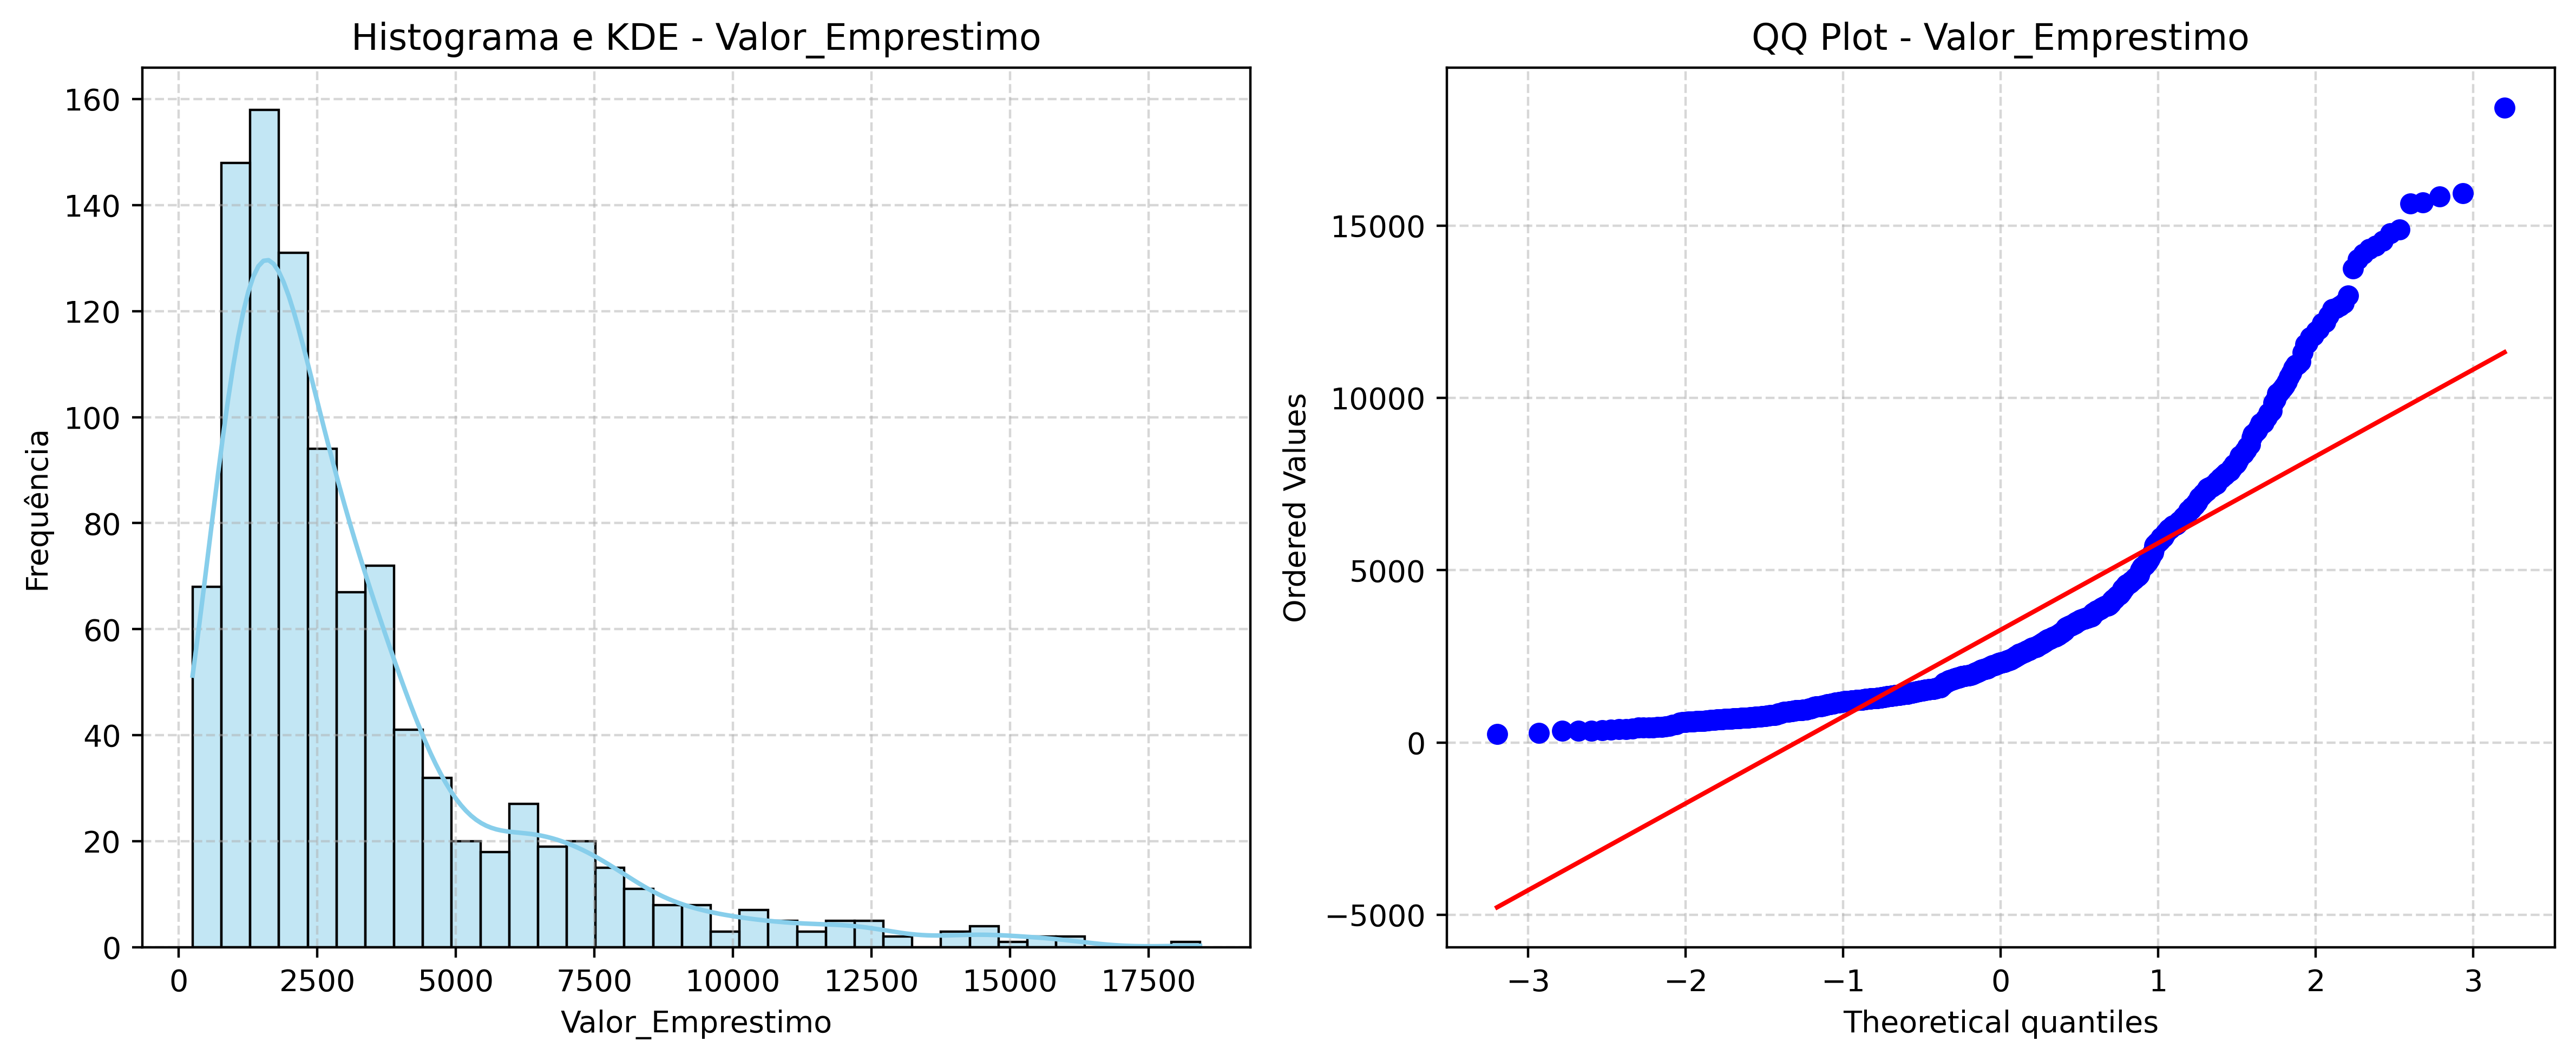

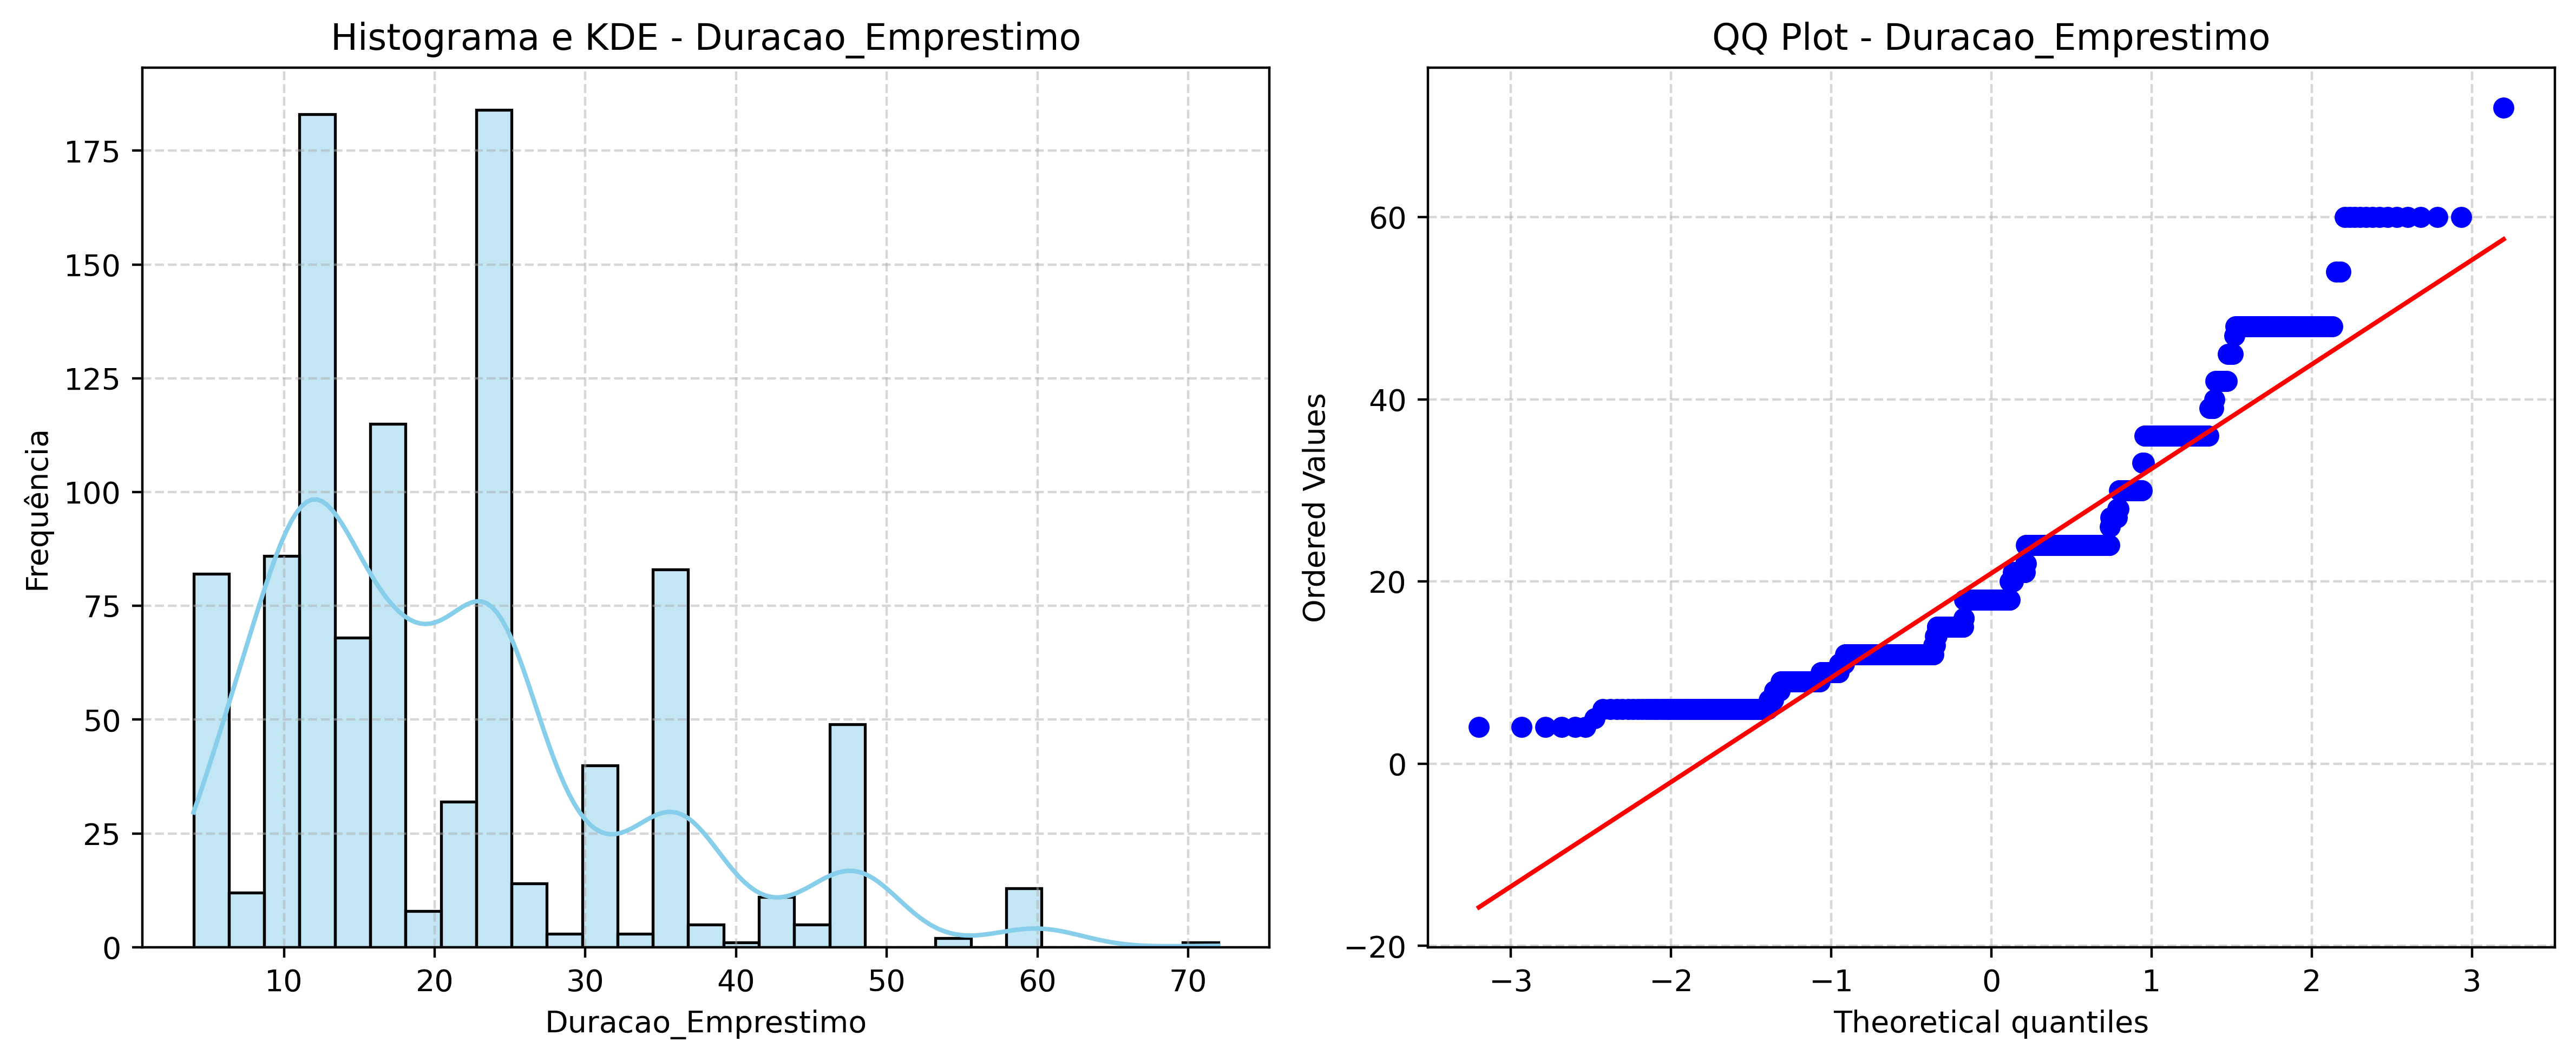

In [18]:
# subplots num_vars
for col in num_vars:
    af.plot_univariate(df, col)

In [19]:
shapiro_results = af.test_normality_shapiro(df, num_vars)
shapiro_results

Variável         W       p-valor                  Interpretação
0               Idade  0.917471  6.382098e-23  Não segue distribuição normal
1    Valor_Emprestimo  0.793396  8.608546e-34  Não segue distribuição normal
2  Duracao_Emprestimo  0.899788  4.906433e-25  Não segue distribuição normal

- Todas as variáveis apresentaram uma forte assimetria (confirmado pelo teste de shapiro);
- A variável `Idade` variou entre 19 a 75 anos, com média de 35 anos. O que para esse tipo de problema é totalmente aceitável;
- A variável `Valor_Emprestimo` se concentrou em valores entre R$250,00 a R$7500,00, com cenários de empréstimos acima dos R$10.000,00. Média de R$3271.25;
- A variável `Duração_Emprestimo` variou entre 4 a 72 meses, demonstrando cenários de curto a longo prazo.

### 2.1.3 Tabelas de Frequência + Análises Visuais (cat_vars)

In [20]:
# Tabelas de Frequencia
for col in cat_vars:
    print('====='*20)
    display(af.freq_table(df, col))

Escolaridade  Frequência Absoluta  Frequência Relativa (%)  \
0      Graduacao                  630                     63.0   
1  Pos Graduacao                  200                     20.0   
2   Ensino Medio                  170                     17.0   

   Frequência Acumulada (%)  
0                      63.0  
1                      83.0  
2                     100.0

Tipo_Moradia  Frequência Absoluta  Frequência Relativa (%)  \
0      Propria                  713                     71.3   
1      Alugada                  179                     17.9   
2     De favor                  108                     10.8   

   Frequência Acumulada (%)  
0                      71.3  
1                      89.2  
2                     100.0

Saldo_Investimento  Frequência Absoluta  Frequência Relativa (%)  \
0              Pouco                  603                     60.3   
1   Sem investimento                  183                     18.3   
2               Alto                  111                     11.1   
3           Moderado                  103                     10.3   

   Frequência Acumulada (%)  
0                      60.3  
1                      78.6  
2                      89.7  
3                     100.0

Saldo_Conta_Corrente  Frequência Absoluta  Frequência Relativa (%)  \
0            Sem conta                  394                     39.4   
1                Pouco                  274                     27.4   
2             Moderado                  224                     22.4   
3                 Alto                  108                     10.8   

   Frequência Acumulada (%)  
0                      39.4  
1                      66.8  
2                      89.2  
3                     100.0

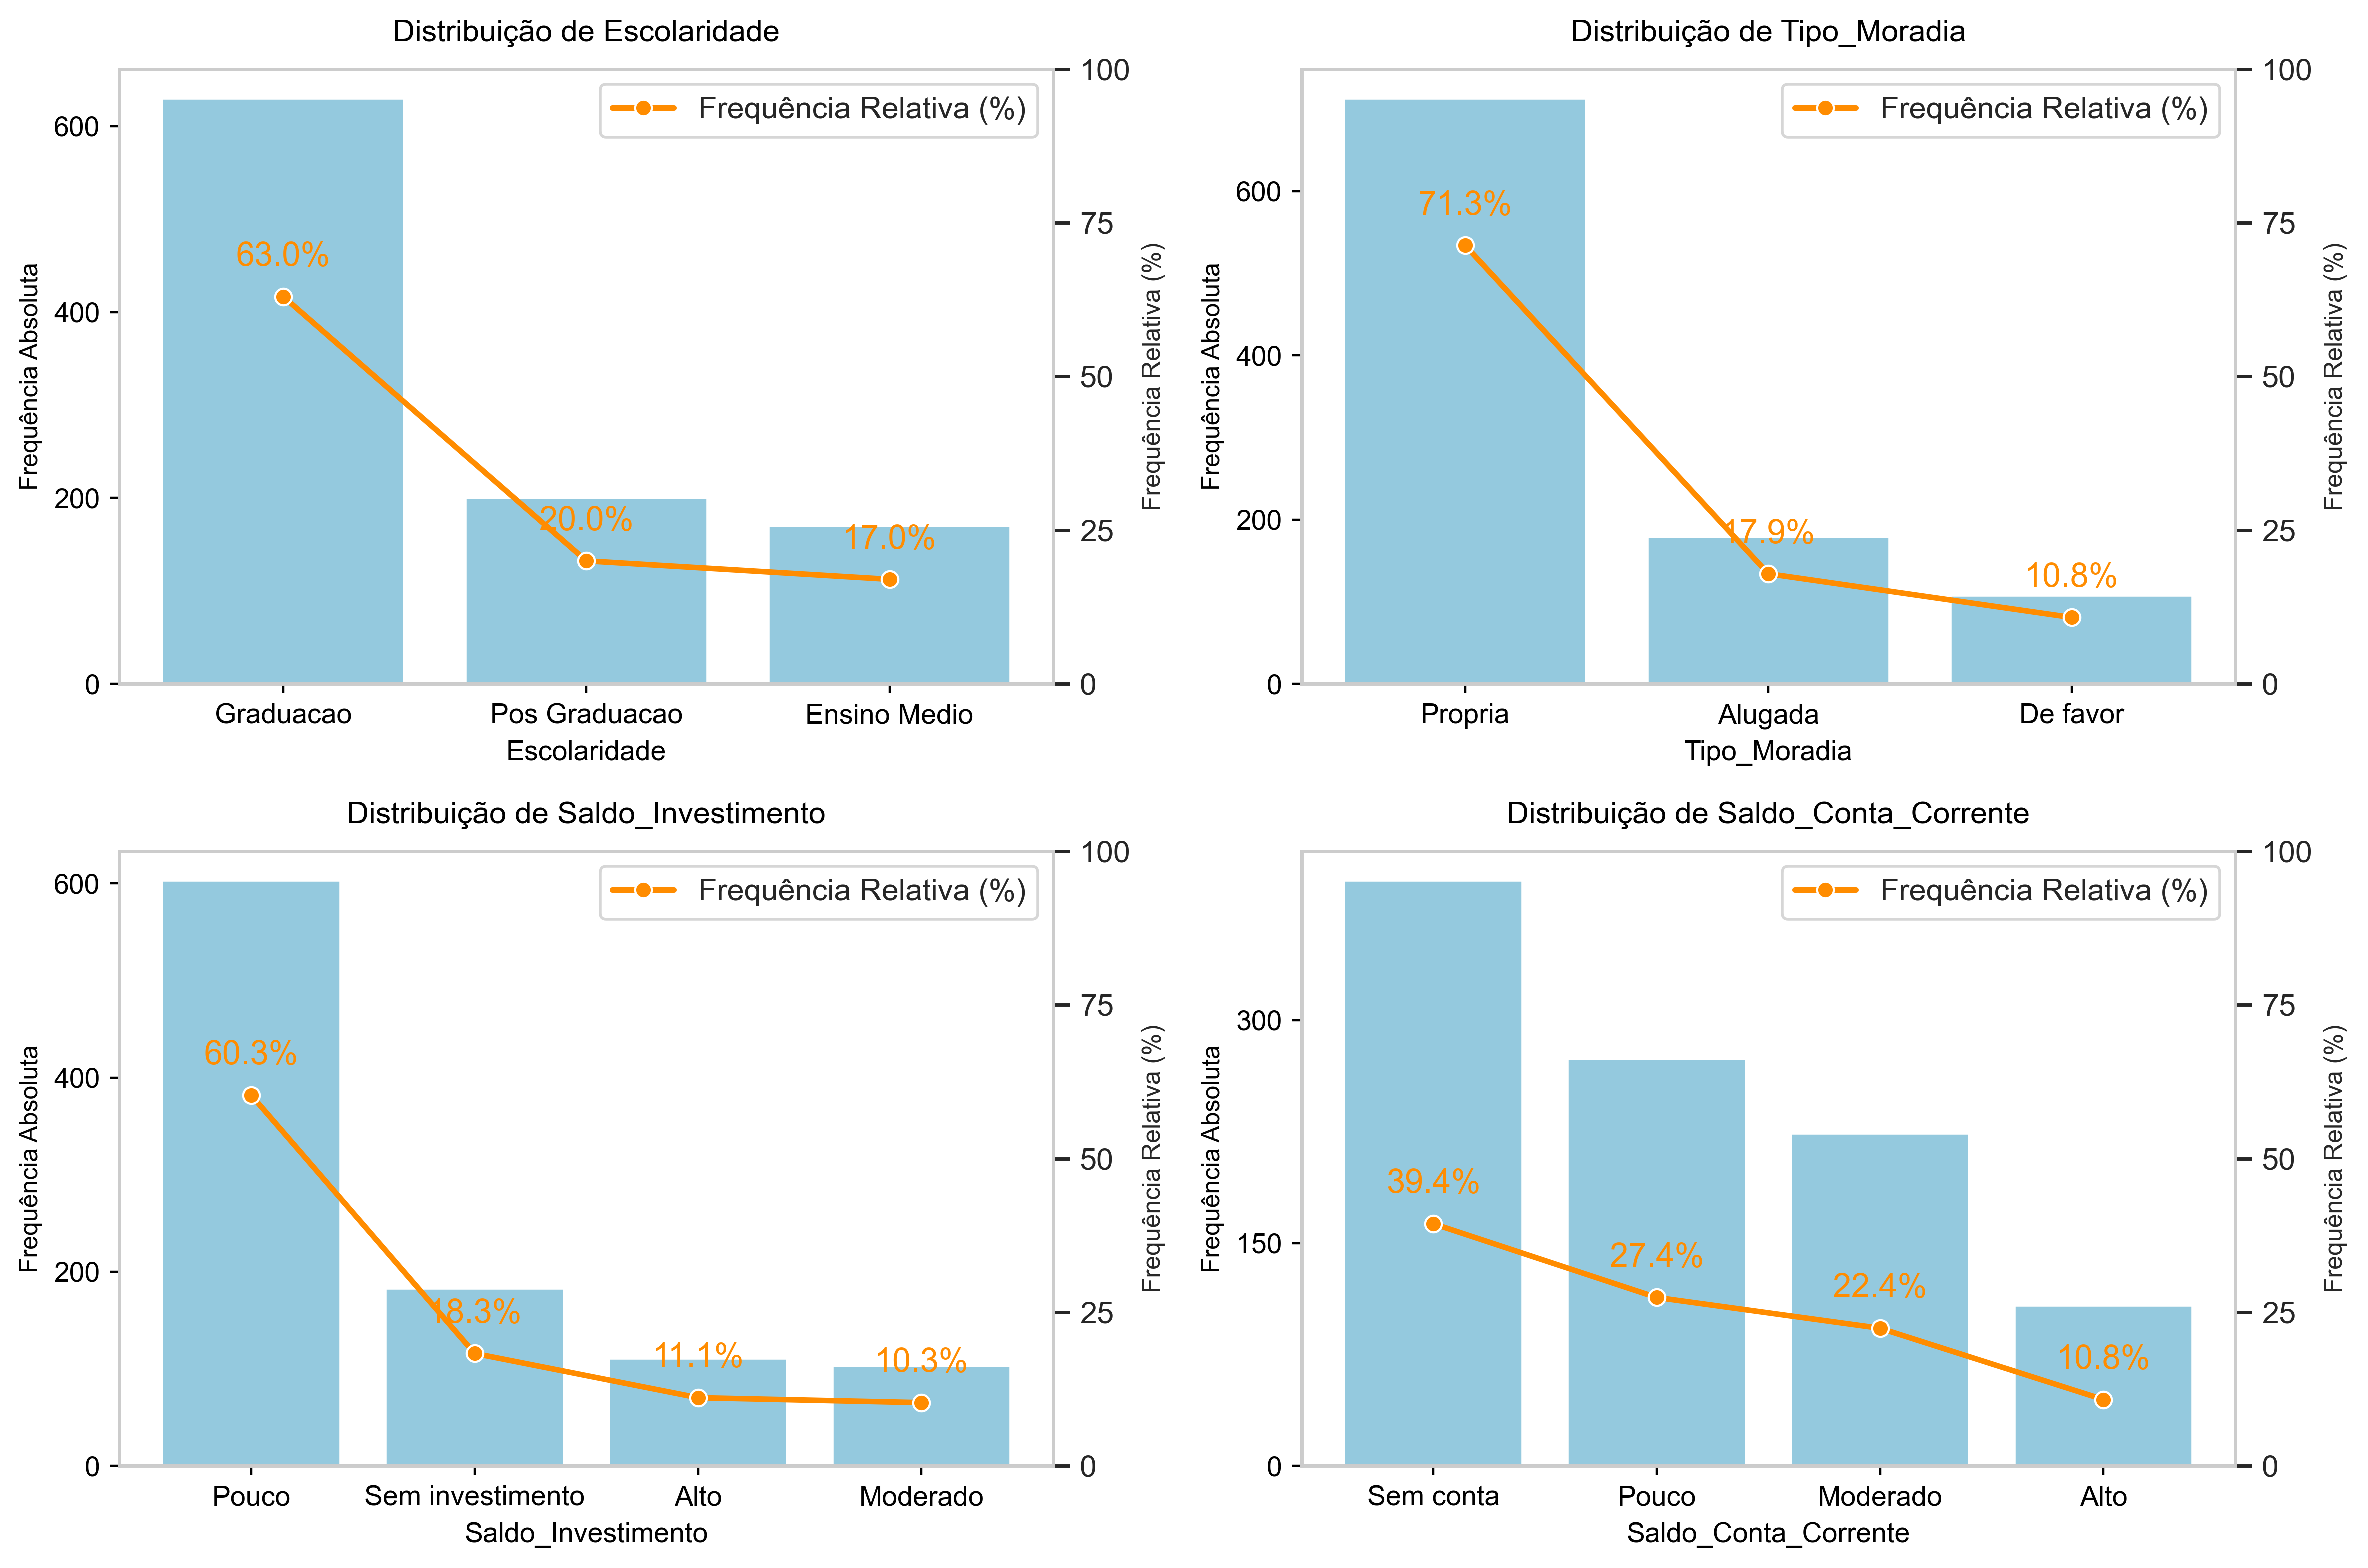

In [21]:
af.grid_freq_bars(df, cat_vars)

### 2.1.4 Balanceamento da Taxa de INADIMPLENCIA (DEFAULT)

In [22]:
df[target].value_counts(normalize=True).mul(100)

Inadimplencia
0    70.0
1    30.0
Name: proportion, dtype: float64

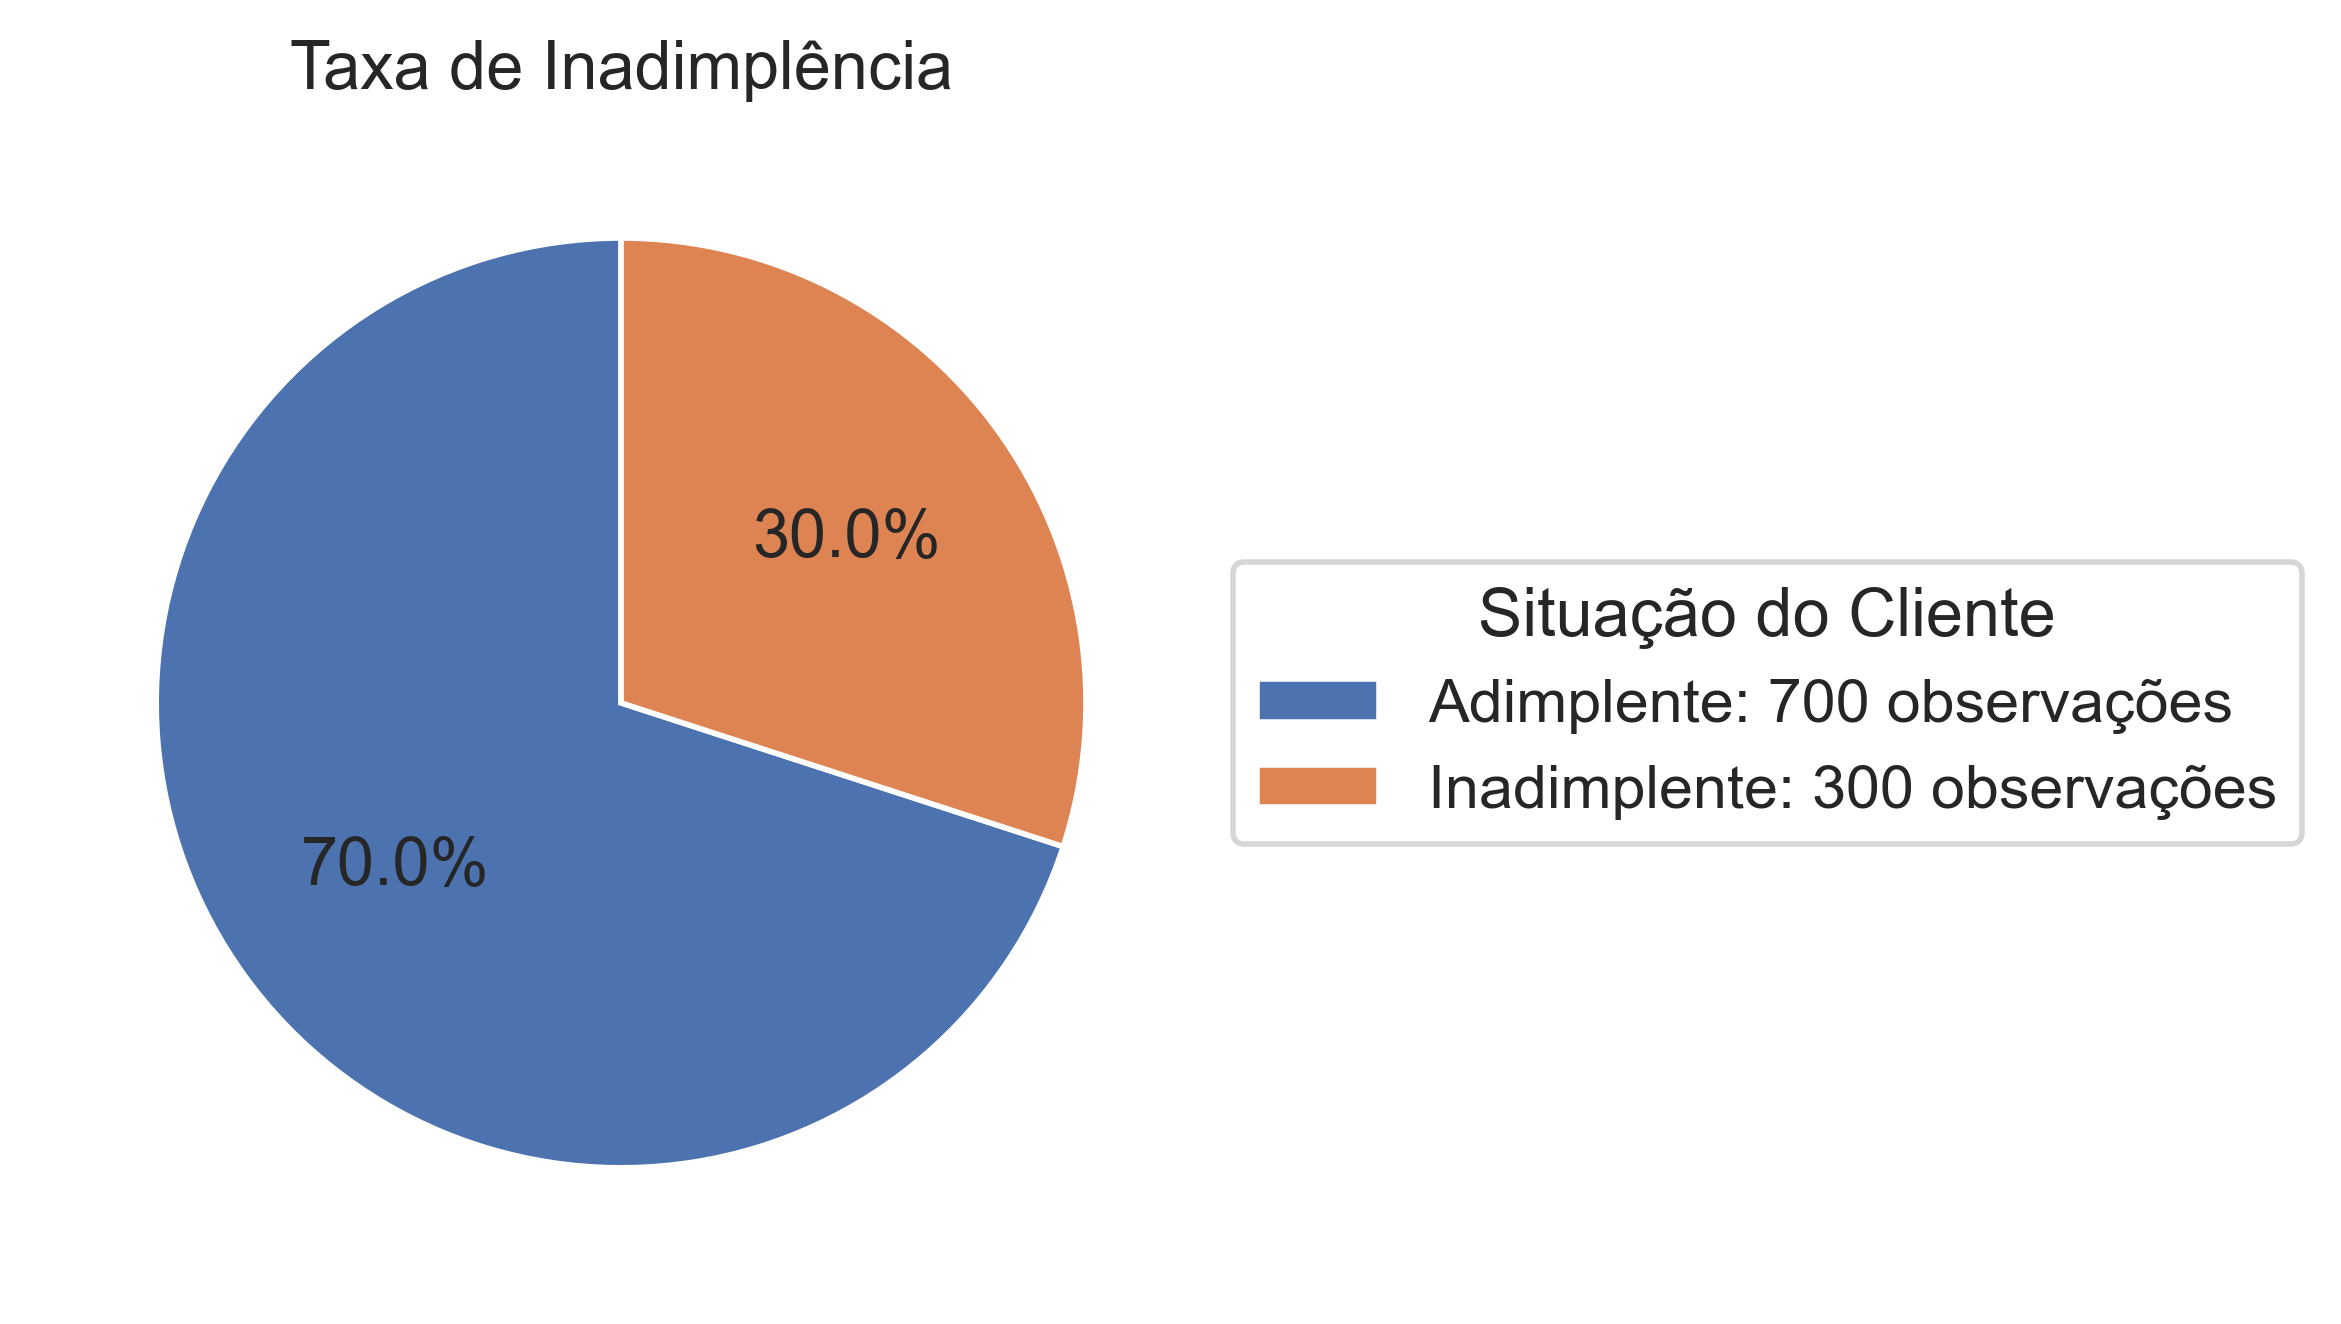

In [23]:
# Estilo seaborn
sns.set_theme(style="whitegrid")

# Contagem da variável target
target_counts = df[target].value_counts().sort_index()
sizes = target_counts.values

# Mapeamento semântico da target
label_map = {
    0: 'Adimplente',
    1: 'Inadimplente'
}

# Plot
plt.figure(figsize=(6, 6))
wedges, _, autotexts = plt.pie(
    sizes,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)

# Legenda informativa
legend_labels = [
    f'{label_map[label]}: {count} observações'
    for label, count in zip(target_counts.index, sizes)
]

plt.legend(
    wedges,
    legend_labels,
    title='Situação do Cliente',
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

plt.title('Taxa de Inadimplência')
plt.tight_layout()
plt.show()

A análise revelou um desbalanceamento moderado, onde 30% dos clientes estudados são inadimplentes. Essa é uma taxa considerada muito alta para se manter nas operações de qualquer organização que trabalhe com liberação de crédito. Espera-se um alto impacto econômico negativo durante a avaliação do baseline econômico.

## 2.2 Análise Bivariada

### 2.2.1 Análise de Correlação/Associação

#### 2.2.1.1 PairPlot (num_vars)

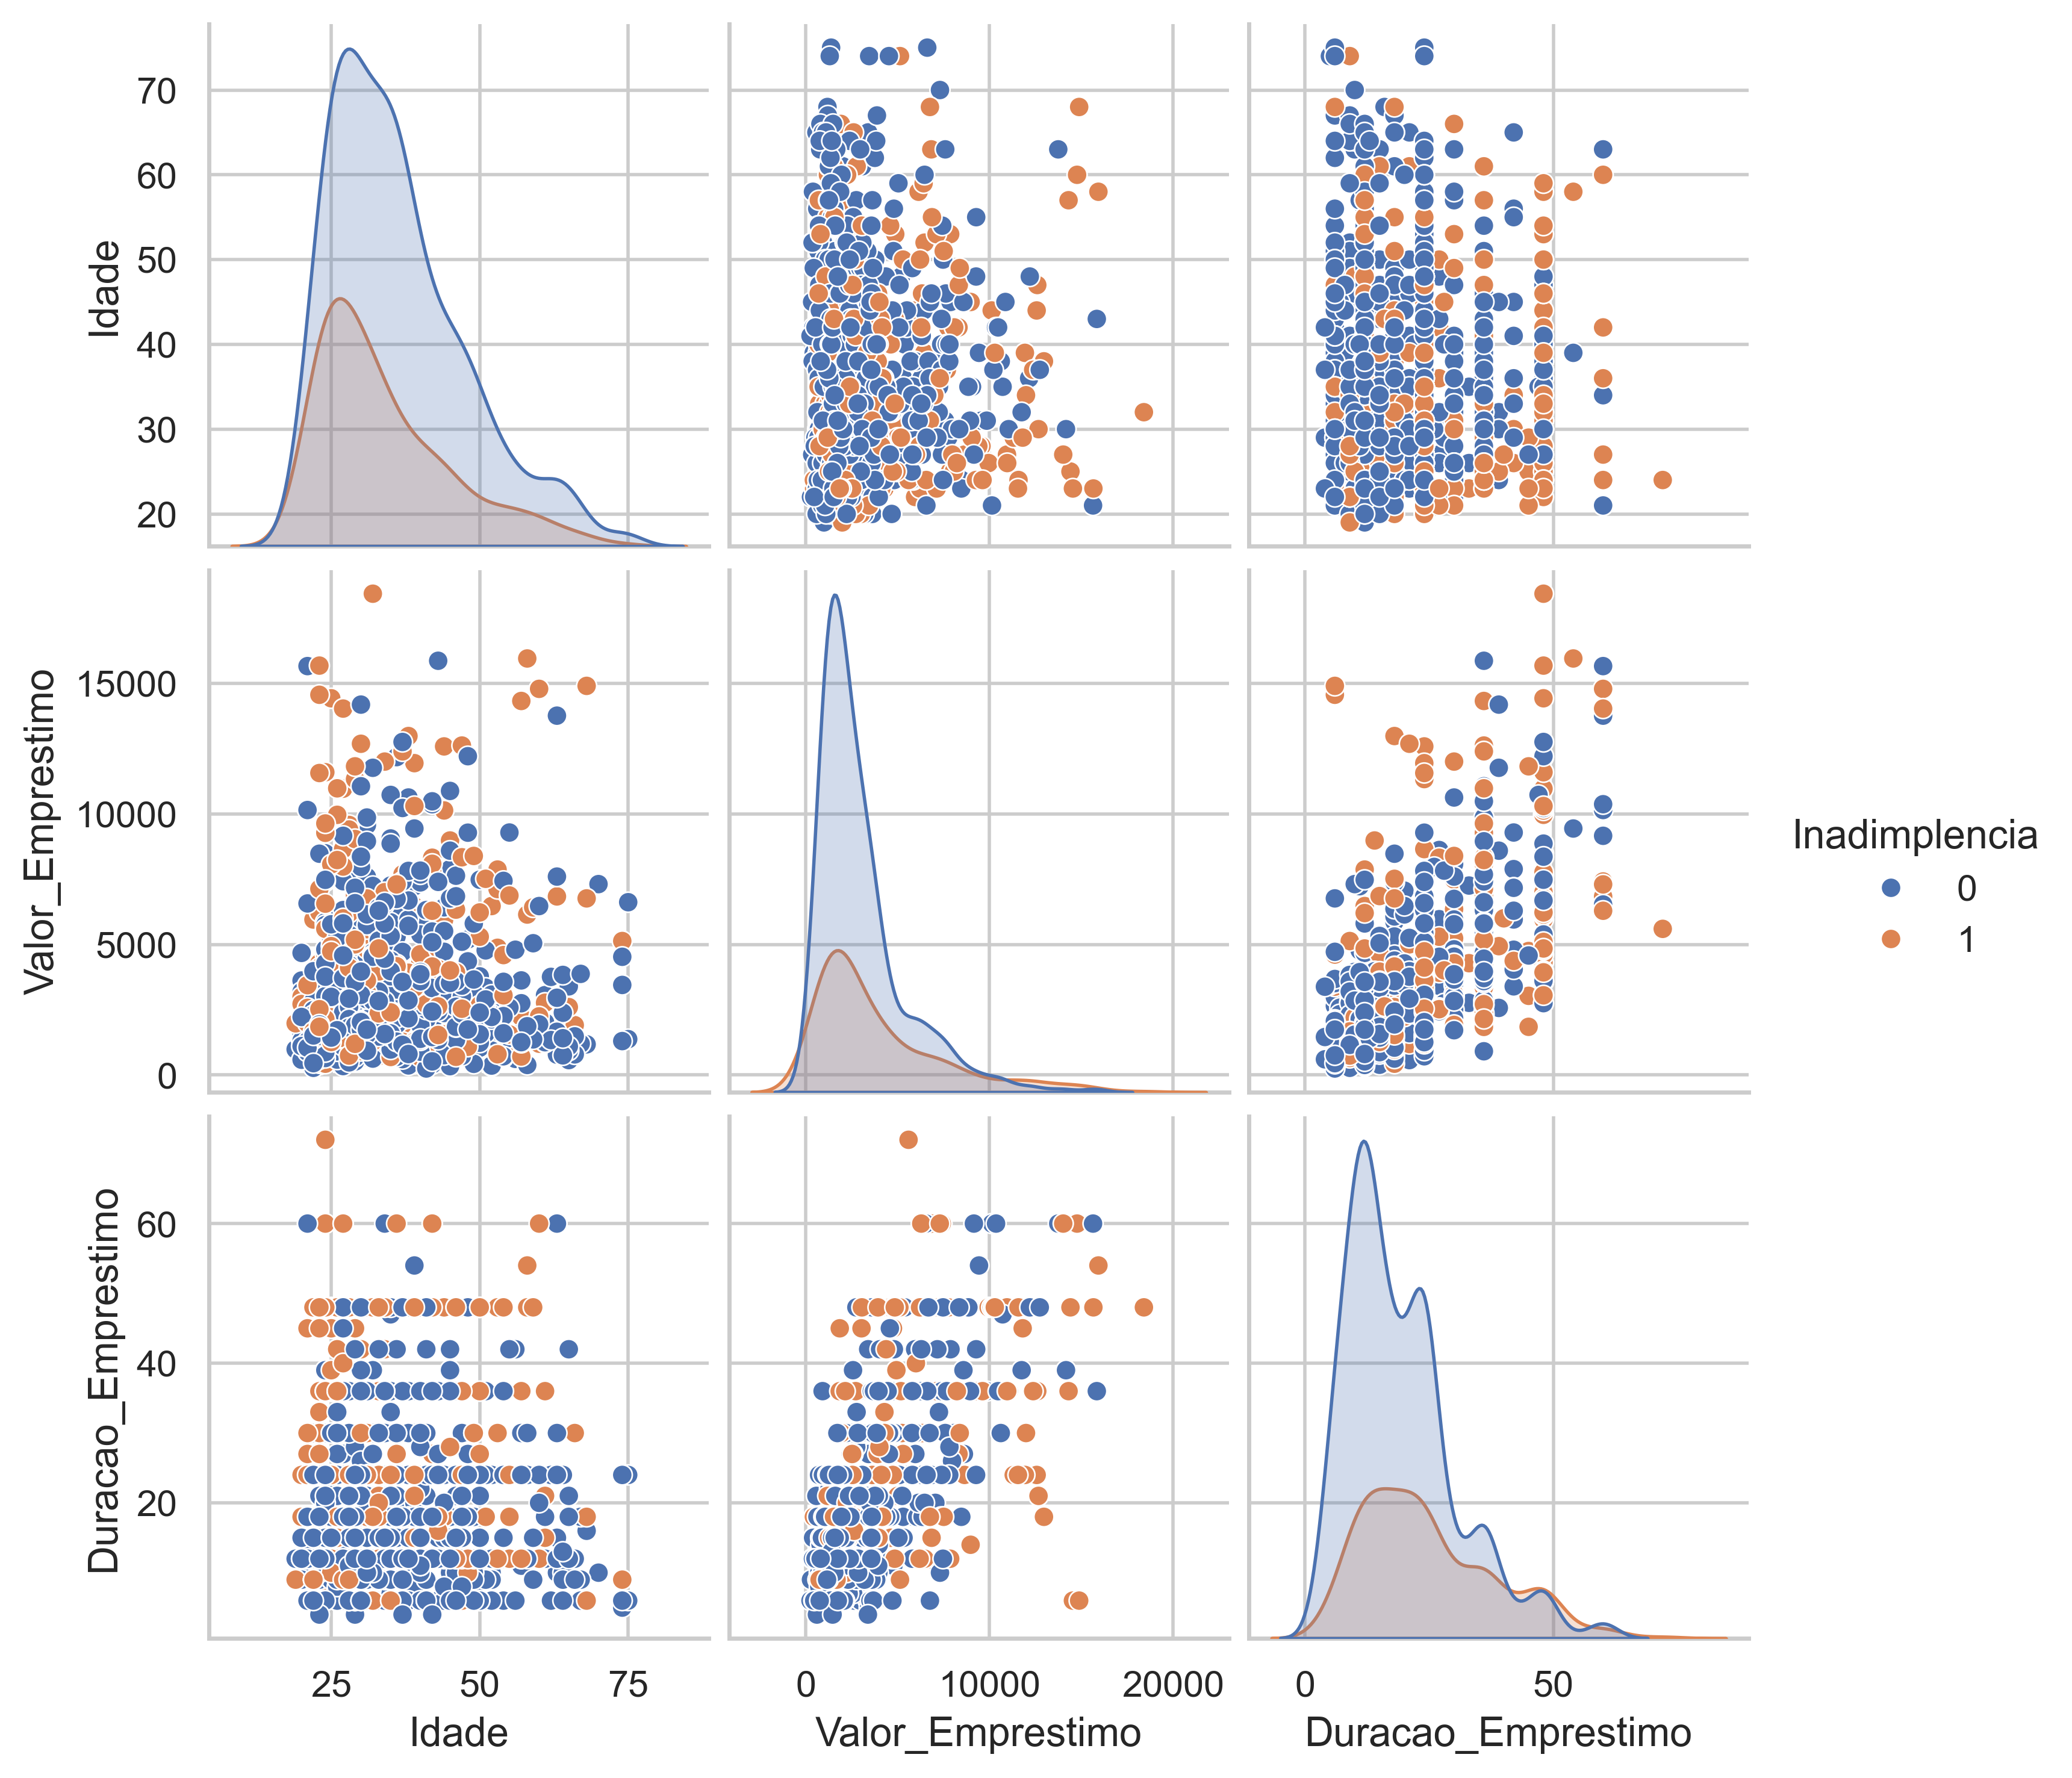

In [24]:
sns.pairplot(df, hue=target)

#### 2.2.1.2 Matriz de Correlação

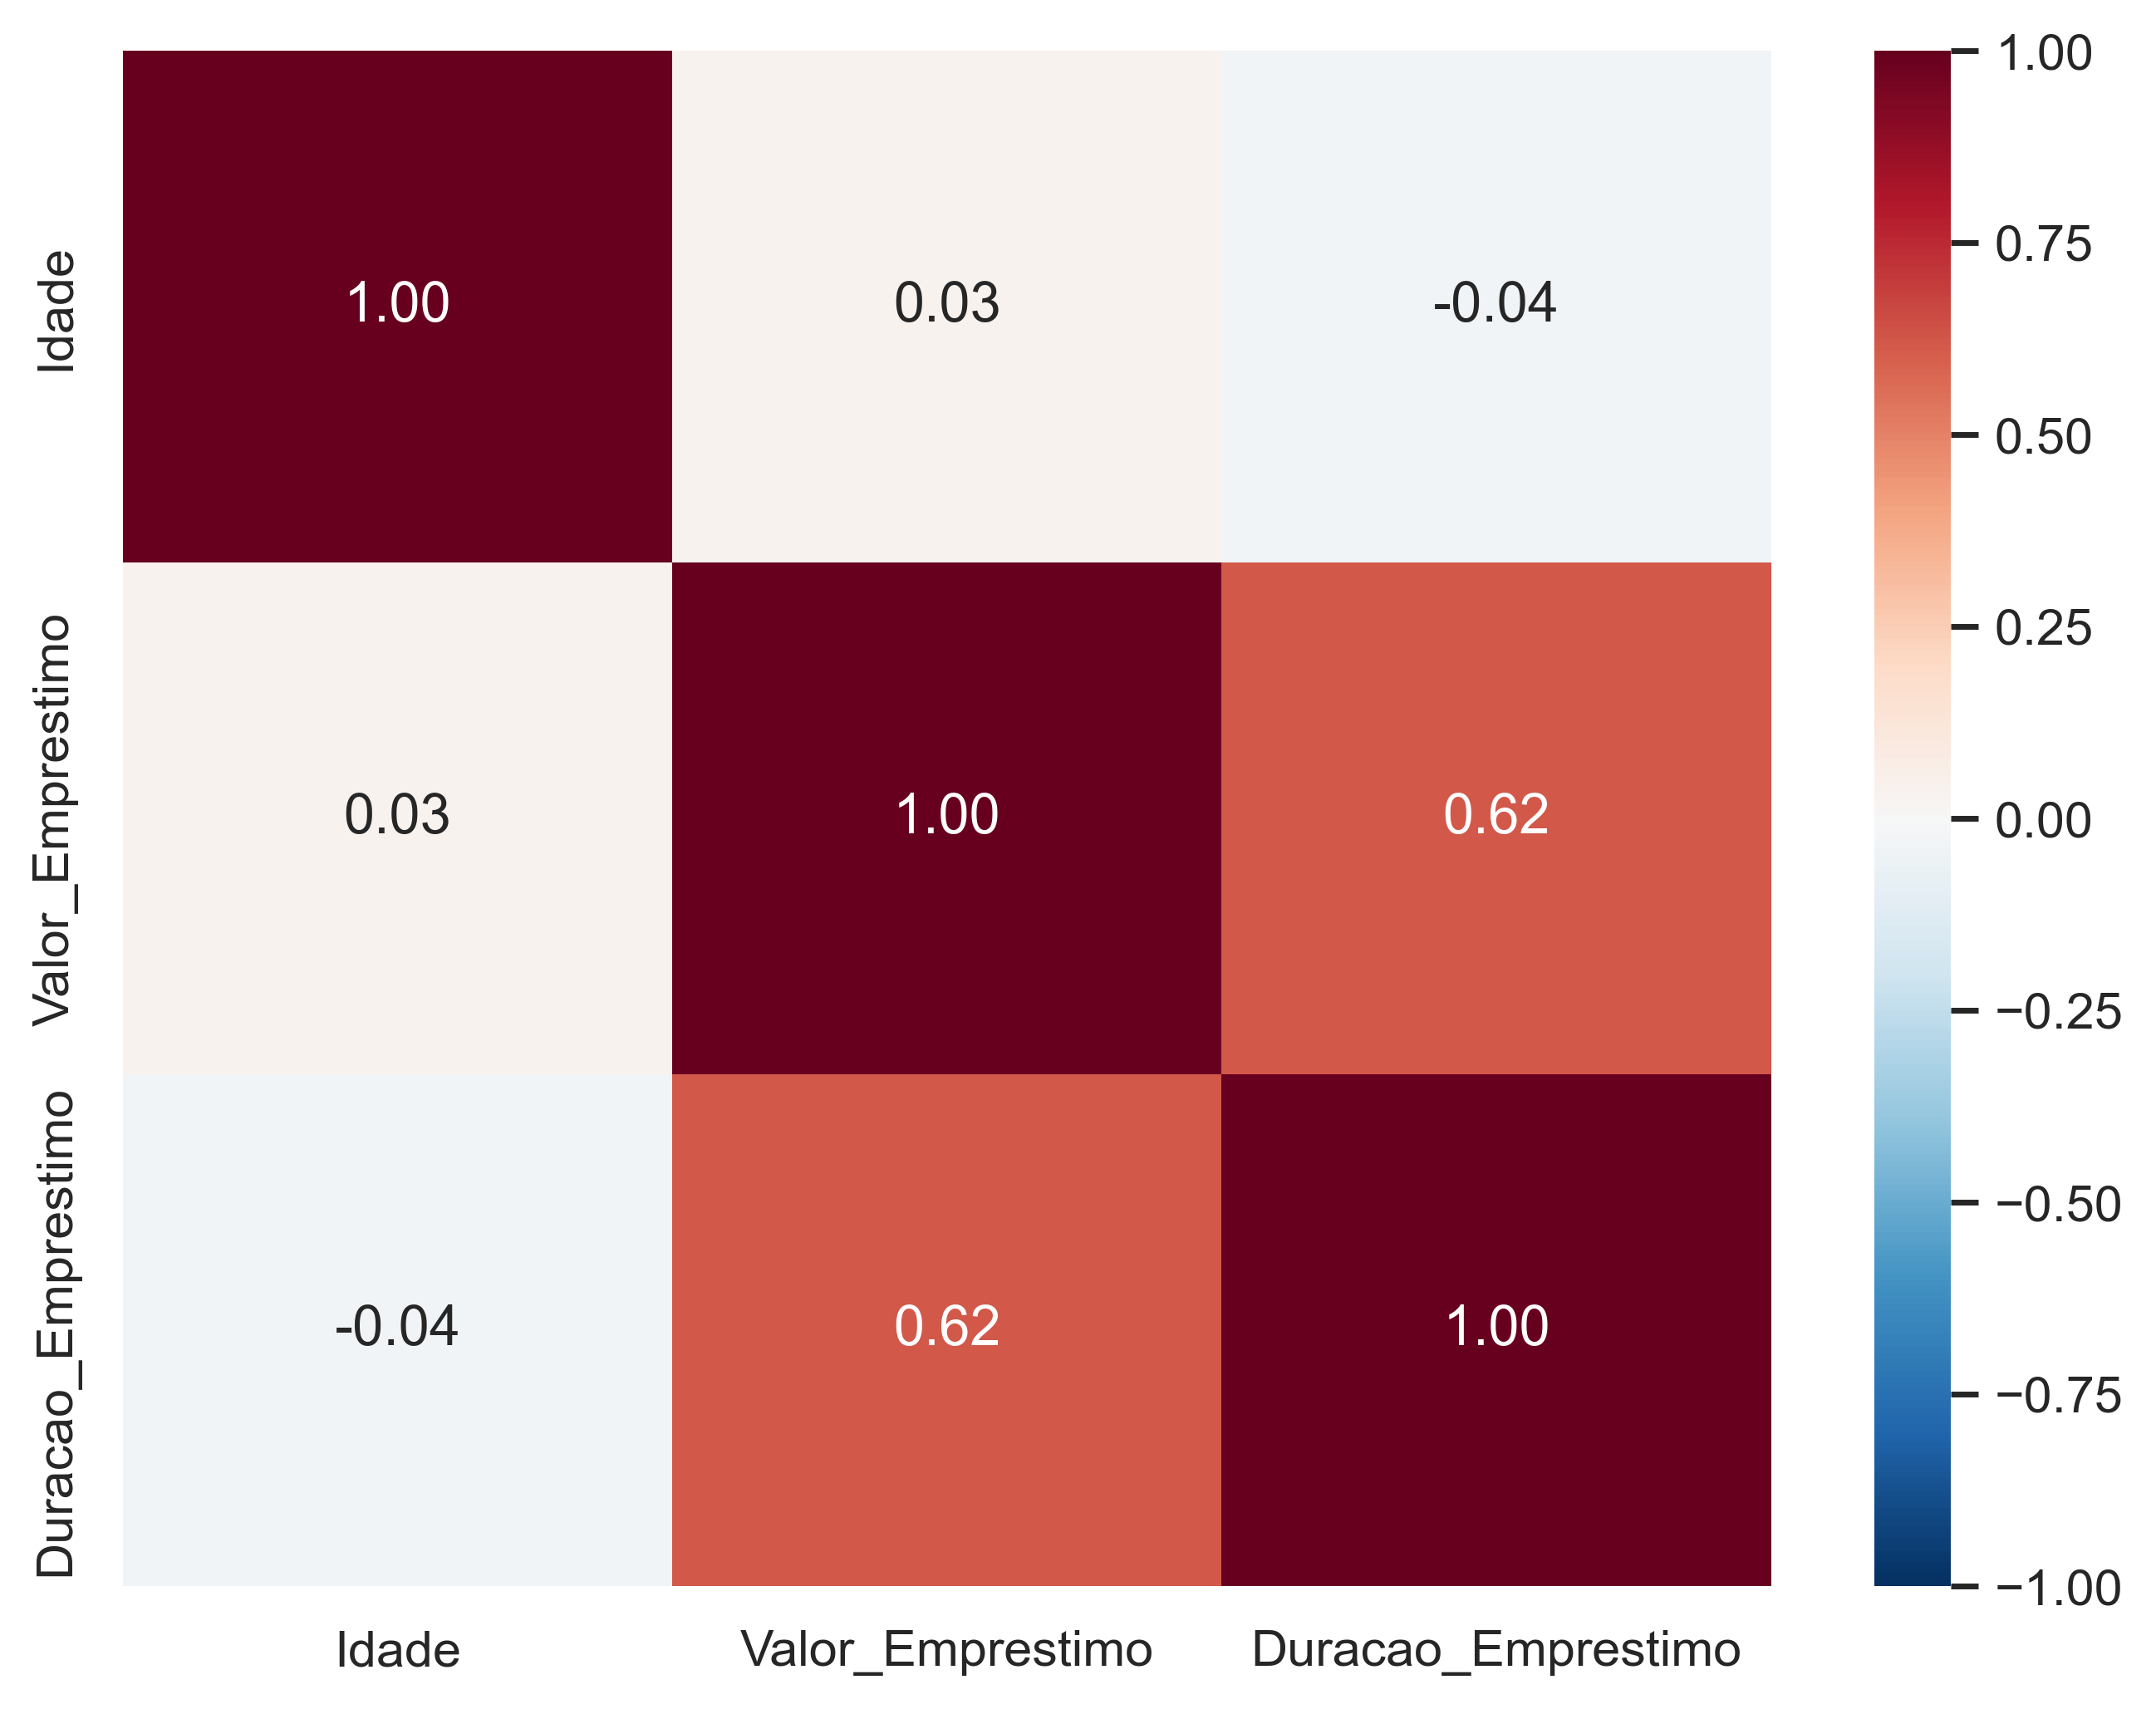

In [25]:
fig = plt.figure(figsize=(8,6))
sns.heatmap(df[num_vars].corr(),
            fmt=".2f",
           cmap='RdBu_r',
           vmin=-1, vmax=1,
           annot=True);

- A variável `Valor_Emprestimo` manteve uma correlação positiva e moderadamente alta com a variável `Duração_Emprestimo` (0.62) podendo implicar uma leve multicolinearidade entre essas variáveis. Esse padrão é considerado normal pelo fato de haver a necessidade mais parcelas conforme o valor do empréstimo aumenta.

#### 2.2.1.3 VIF

In [26]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, features):
    """
    Calcula o VIF (Variance Inflation Factor) para um conjunto de variáveis numéricas.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame contendo os dados.
    features : list
        Lista de variáveis numéricas para cálculo do VIF.

    Returns
    -------
    pd.DataFrame
        DataFrame com VIF por variável.
    """
    X = df[features].dropna()

    vif_df = pd.DataFrame()
    vif_df['variavel'] = X.columns
    vif_df['VIF'] = [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]

    return vif_df.sort_values('VIF', ascending=False).reset_index(drop=True)


In [27]:
def classify_vif(vif_df):
    """
    Classifica o grau de multicolinearidade com base no VIF.

    Regras adotadas:
    - VIF < 5       : Baixa multicolinearidade
    - 5 ≤ VIF < 10  : Multicolinearidade moderada
    - VIF ≥ 10      : Alta multicolinearidade
    """
    conditions = [
        vif_df['VIF'] < 5,
        (vif_df['VIF'] >= 5) & (vif_df['VIF'] < 10),
        vif_df['VIF'] >= 10
    ]

    choices = [
        'Baixa multicolinearidade',
        'Multicolinearidade moderada',
        'Alta multicolinearidade'
    ]

    vif_df['Classificacao'] = np.select(
        conditions,
        choices,
        default='Não classificado'
    )

    return vif_df


In [28]:
vif_df = calculate_vif(df, num_vars)
vif_df = classify_vif(vif_df)
vif_df


variavel       VIF                Classificacao
0  Duracao_Emprestimo  5.534221  Multicolinearidade moderada
1    Valor_Emprestimo  3.861919     Baixa multicolinearidade
2               Idade  3.065675     Baixa multicolinearidade

  Como esperado, a variável `Duracao_Emprestimo` apresentou multicolinearidade moderada. Em termos práticos, há redundância parcial de informação. Embora esse nível não comprometa necessariamente o poder preditivo, pode afetar a estabilidade e interpretação dos coeficientes em modelos lineares. Dessa forma, tais variáveis foram avaliadas individualmente quanto à relevância preditiva, estabilidade e coerência de negócio antes de decisões de exclusão ou transformação.

### 2.2.2 Análise IV - WOE

In [29]:
df_iv = af.AnaliseIV(df[cat_vars + [target]], target=target, convention="good_over_bad")
df_iv.get_lista_iv()

Variavel     IV                               Forca_Preditiva
0  Saldo_Conta_Corrente  0.729  Muito forte (verificar possível overfitting)
1    Saldo_Investimento  0.192                                         Média
2          Tipo_Moradia  0.083                                         Fraca
3          Escolaridade  0.008                                   Irrelevante

A análise exploratória de Information Value (IV) indica forte heterogeneidade no poder discriminatório das variáveis. Enquanto variáveis financeiras contínuas apresentam maior capacidade de separação entre eventos e não eventos, variáveis socioeconômicas categóricas demonstram contribuição marginal no contexto atual. Destaca-se que valores de IV muito elevados podem sinalizar possíveis riscos de vazamento de informação ou instabilidade temporal, reforçando a necessidade de análises adicionais antes da incorporação dessas variáveis na modelagem.

In [30]:
df_iv.get_bivariada(var='Saldo_Conta_Corrente')

Inadimplencia  Var_Range  NonEvent  Event  Total  Dist_Event  Dist_NonEvent  \
0                   Alto        87     21    108    0.070000       0.124286   
1               Moderado       126     98    224    0.326667       0.180000   
2                  Pouco       139    135    274    0.450000       0.198571   
3              Sem conta       348     46    394    0.153333       0.497143   

Inadimplencia       WOE        IV              Variavel  
0              0.574088  0.031165  Saldo_Conta_Corrente  
1             -0.595983  0.087411  Saldo_Conta_Corrente  
2             -0.818099  0.205693  Saldo_Conta_Corrente  
3              1.176263  0.404410  Saldo_Conta_Corrente

A variável `Saldo_Conta_Corrente` apresenta IV elevado, impulsionado majoritariamente pela categoria **Sem conta**, que concentra uma parcela significativa dos não inadimplentes. Essa variável apresenta um padrão de WOE não estritamente monotônico, com um comportamento em formato de U. Do ponto de vista exploratório, esse achado não é um problema em si, precisamos levantar causas que justifique o porque de pessoas sem conta corrente tendem a ser melhor pagadora do que os que possuem conta. Agora, do ponto de vista da modelagem, precisamos ter um pouco de atenção. Modelos de classificação lineares, como a Regressão Logística, esperam uma relação linear no log-odds, o que não é o caso com essa variável. Isso pode gerar coeficientes instáveis com sinais invertidos, dificultando a interpretação. Nesse caso, a solução pode ser um merge entre categorias ao invés de impor monotonicidade através da codificação dessas variáveis. Uma outra solução seria usar modelos baseados em árvore de decisão que lidam naturalmente com relação não-lineares.

### 2.2.3 Boxplots (Target x Pred)

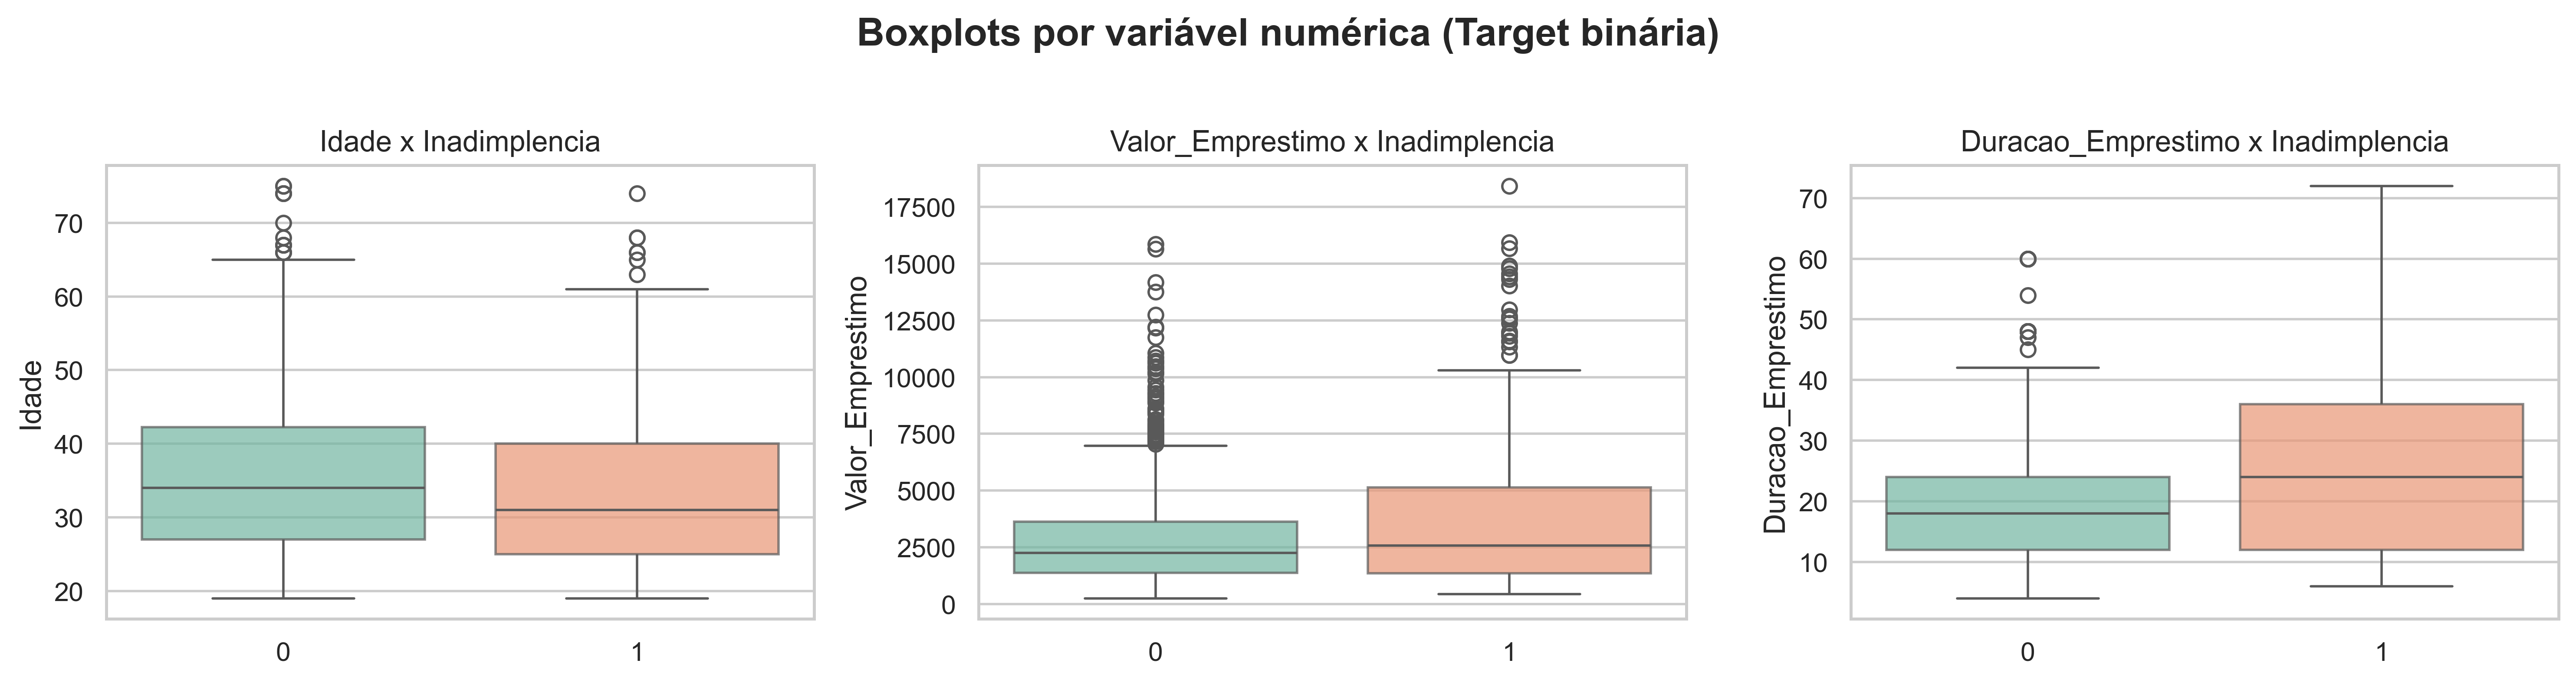

In [31]:
af.boxplots_target_binaria(df, target, num_vars)

A análise dos boxplots entre a variável target binária e as variáveis numéricas revelou os seguintes pontos:
- A Idade do grupo de inadimplentes apresentou uma mediana ligeiramente menor do que a do grupo de adimplentes;
- Com relação ao valor do empréstimo, não conseguimos obter uma diferenciação muito grande. Os gráficos estão bem sobrepostos com uma maior variabilidade no grupo de inadimplentes. Isso mostra que o valor do empréstimo não é um fator determinante para uma pessoa ser boa pagadora ou não;
- A duração do empréstimo apresentou medianas moderadamente distintas, sendo maior nos casos de inadimplência;
- A sobreposição dos boxplots dificulta na obtenção de informações mais precisas, seria interessante abordarmos um outro tipo de visualização para confirmar as hipóteses levantadas anteriormente.

### 2.2.4 Outros Gráficos

In [32]:
disc_vars = ['Idade', 'Duracao_Emprestimo']
cont_vars = ['Valor_Emprestimo']

In [33]:
def grid_disc_binario(df, target, disc_vars, n_cols=3):
    """
    Cria um grid de gráficos de linha mostrando a proporção da classe positiva
    para variáveis discretas ou ordinais em um problema de classificação binária.

    Parâmetros
    ----------
    df : pandas.DataFrame
        Base de dados.
    target : str
        Nome da variável alvo binária (0/1 ou duas classes).
    disc_vars : list
        Lista de variáveis discretas/ordinais.
    n_cols : int, default=3
        Número de colunas do grid de visualização.
    """

    if not disc_vars:
        print("⚠️ Nenhuma variável discreta/ordinal informada.")
        return

    sns.set(style="whitegrid", palette="Set2", font_scale=1.0)

    n_disc = len(disc_vars)
    ncols = n_cols
    nrows = int(np.ceil(n_disc / ncols))

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(5 * ncols, 4 * nrows)
    )

    axes = np.array(axes).reshape(-1)

    media_global = df[target].mean()

    for i, col in enumerate(disc_vars):
        prop = (
            df
            .groupby(col, dropna=False)[target]
            .mean()
            .reset_index()
        )

        sns.lineplot(
            data=prop,
            x=col,
            y=target,
            marker='o',
            ax=axes[i],
            color='tab:blue'
        )

        axes[i].axhline(
            y=media_global,
            color='red',
            linestyle='--',
            label=f'Média global = {media_global:.2f}'
        )

        axes[i].set_title(col)
        axes[i].set_ylabel("Proporção da classe positiva")
        axes[i].set_xlabel(col)
        axes[i].legend()

    # Remove eixos extras
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(
        "Variáveis Discretas — Proporção da Classe Positiva",
        fontsize=14,
        y=1.02
    )

    plt.tight_layout()
    plt.show()


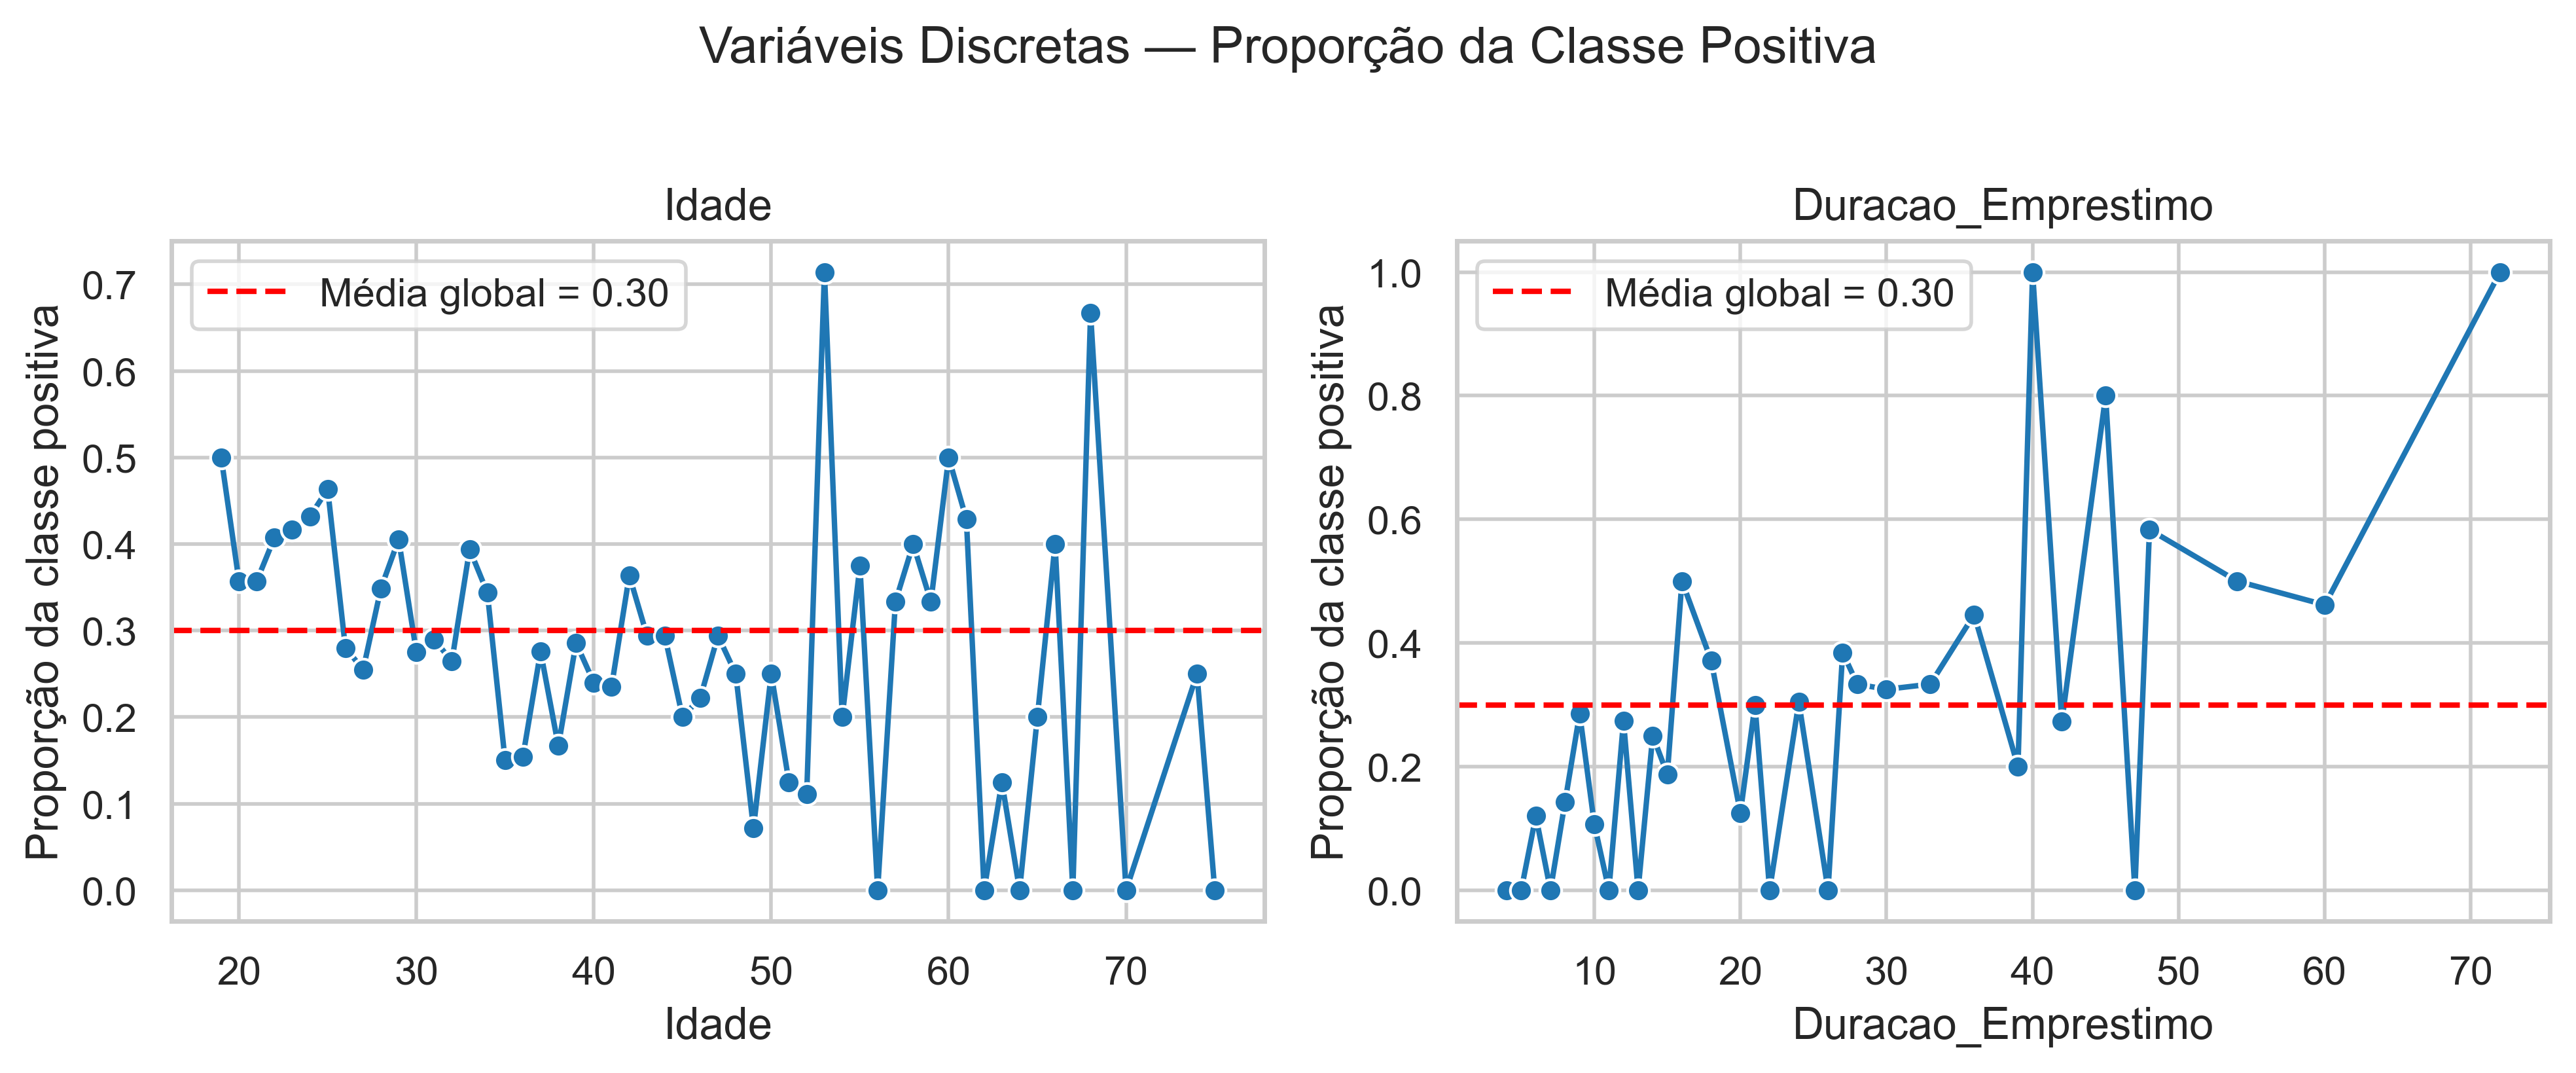

In [34]:
grid_disc_binario(df, target, disc_vars, n_cols=2)

- Com relação a variável `Idade`, podemos perceber que a taxa de inadimplência tende a cair conforme a idade aumenta. Esse comportamento observado no gráfico confirma a hipótese levantada pela análise do boxplot, onde a mediana do grupo inadimplente foi inferior a mediana do grupo adimplente. Isso sugere que clientes mais novos estão mais propensos a se tornarem inadimplentes do que os clientes mais velhos;
- Com relação a variável `Duracao_Emprestimo`, observamos um aumento na taxa de inadimplência conforme a duração do empréstimo aumenta. Essa percepção corrobora com o comportamento observado no boxplot anterior, reforçando o achado de que empréstimos muito longo possuem maior risco de se tornarem inadimplentes.

In [67]:
def grid_cont_binario(df, target, cont_vars, bins=20, n_cols=3):
    """
    Cria um grid de histogramas normalizados (densidades) para variáveis contínuas
    em um problema de classificação binária.

    Parâmetros
    ----------
    df : pandas.DataFrame
        Base de dados.
    target : str
        Nome da variável alvo binária (0/1 ou duas classes).
    cont_vars : list
        Lista de variáveis contínuas.
    bins : int, default=20
        Número de bins dos histogramas.
    n_cols : int, default=3
        Número de colunas do grid.
    """

    if not cont_vars:
        print("⚠️ Nenhuma variável contínua informada.")
        return

    sns.set(style="whitegrid", palette="Set2", font_scale=1.0)

    n_cont = len(cont_vars)
    ncols = n_cols
    nrows = int(np.ceil(n_cont / ncols))

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(5 * ncols, 4 * nrows)
    )
    axes = np.array(axes).reshape(-1)

    pos_mask = df[target] == 1
    neg_mask = df[target] == 0

    for i, col in enumerate(cont_vars):
        x_pos = df.loc[pos_mask, col].dropna()
        x_neg = df.loc[neg_mask, col].dropna()

        # Normalização empírica: densidades que somam 1
        if len(x_pos) > 0 and len(x_neg) > 0:
            width_pos = (x_pos.max() - x_pos.min()) / bins
            width_neg = (x_neg.max() - x_neg.min()) / bins

            weights_pos = np.ones_like(x_pos) / (len(x_pos) * width_pos)
            weights_neg = np.ones_like(x_neg) / (len(x_neg) * width_neg)

            sns.histplot(
                x=x_pos,
                bins=bins,
                color='tab:blue',
                alpha=0.6,
                ax=axes[i],
                stat="density",
                weights=weights_pos,
                label="Classe Positiva"
            )

            sns.histplot(
                x=x_neg,
                bins=bins,
                color='tab:orange',
                alpha=0.6,
                ax=axes[i],
                stat="density",
                weights=weights_neg,
                label="Classe Negativa"
            )

            axes[i].set_title(col)
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Proporção / Densidade Normalizada")
            axes[i].legend()

    # Remove eixos extras
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle(
        "Variáveis Contínuas — Distribuições Normalizadas",
        fontsize=14,
        y=1.02
    )
    plt.show()


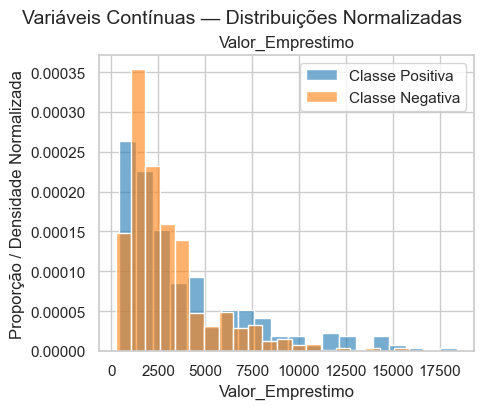

In [68]:
grid_cont_binario(df, target, cont_vars, n_cols=1)

A análise das distribuições normalizadas permitiu identificar que empréstimos de valores mais altos tendem a correr o risco de inadimplência. Embora as distribuições estejam bem sobrepostas, é bem perceptível a diferenciação nos casos de valores extremos, tanto para os casos de valores mais baixos quanto para os casos de valores mais altos. Isso confirma a hipótese de que talvez essa variável não consiga oferecer tanto poder preditivo na identificação dos casos de inadimplência, uma vez que temos casos em ambas as faixas de valor de empréstimo que são correspondente ao evento positivo.

In [37]:
def grid_cat_freq_event_rate(df, cat_vars, target, n_cols=2):
    """
    Cria um grid de gráficos combinados para variáveis categóricas:
    - Barras: frequência relativa (%)
    - Linha: taxa da classe positiva (%)
    - Linha pontilhada vermelha: taxa média global
    - Rótulos percentuais nos pontos da linha
    """

    if not cat_vars:
        print("⚠️ Nenhuma variável categórica informada.")
        return

    sns.set_theme(style="whitegrid", font_scale=1.0)

    n_vars = len(cat_vars)
    n_rows = int(np.ceil(n_vars / n_cols))

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(6 * n_cols, 4 * n_rows)
    )

    axes = np.array(axes).reshape(-1)

    # Taxa média global da classe positiva (%)
    taxa_global = df[target].mean() * 100

    for i, var in enumerate(cat_vars):
        ax = axes[i]

        # Frequência relativa (%)
        freq = (
            df[var]
            .value_counts(normalize=True, dropna=False)
            .sort_index()
            * 100
        )

        # Taxa da classe positiva (%)
        event_rate = (
            df
            .groupby(var, dropna=False)[target]
            .mean()
            .loc[freq.index]
            * 100
        )

        # Barras — frequência relativa
        ax.bar(
            freq.index.astype(str),
            freq.values,
            color="#93C5FD",
            edgecolor="white",
            label="Frequência (%)"
        )

        ax.set_ylim(0, 100)
        ax.set_ylabel("Frequência Relativa (%)")

        # Segundo eixo — taxa de evento
        ax2 = ax.twinx()
        ax2.plot(
            freq.index.astype(str),
            event_rate.values,
            color="#F97316",
            marker="o",
            linewidth=2,
            label="Taxa da Classe Positiva (%)"
        )

        # Linha da média global
        ax2.axhline(
            y=taxa_global,
            color="red",
            linestyle="--",
            linewidth=0.8,
            alpha=0.7,
            label=f"Média global = {taxa_global:.1f}%"
        )

        ax2.set_ylim(0, 100)
        ax2.set_ylabel("Taxa da Classe Positiva (%)")

        # 🔹 Rótulos percentuais nos pontos da linha
        for x, y in zip(freq.index.astype(str), event_rate.values):
            ax2.annotate(
                f"{y:.1f}%",
                xy=(x, y),
                xytext=(0, 5),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=9,
                color="black"
            )

        # Título e ajustes
        ax.set_title(var)
        ax.tick_params(axis="x", rotation=45)

        # Legenda combinada
        lines_1, labels_1 = ax.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax.legend(
            lines_1 + lines_2,
            labels_1 + labels_2,
            loc="upper right",
            frameon=False
        )

    # Remove eixos vazios
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(
        "Variáveis Categóricas — Frequência Relativa e Taxa da Classe Positiva",
        fontsize=14,
        y=1.02
    )

    plt.tight_layout()
    plt.show()


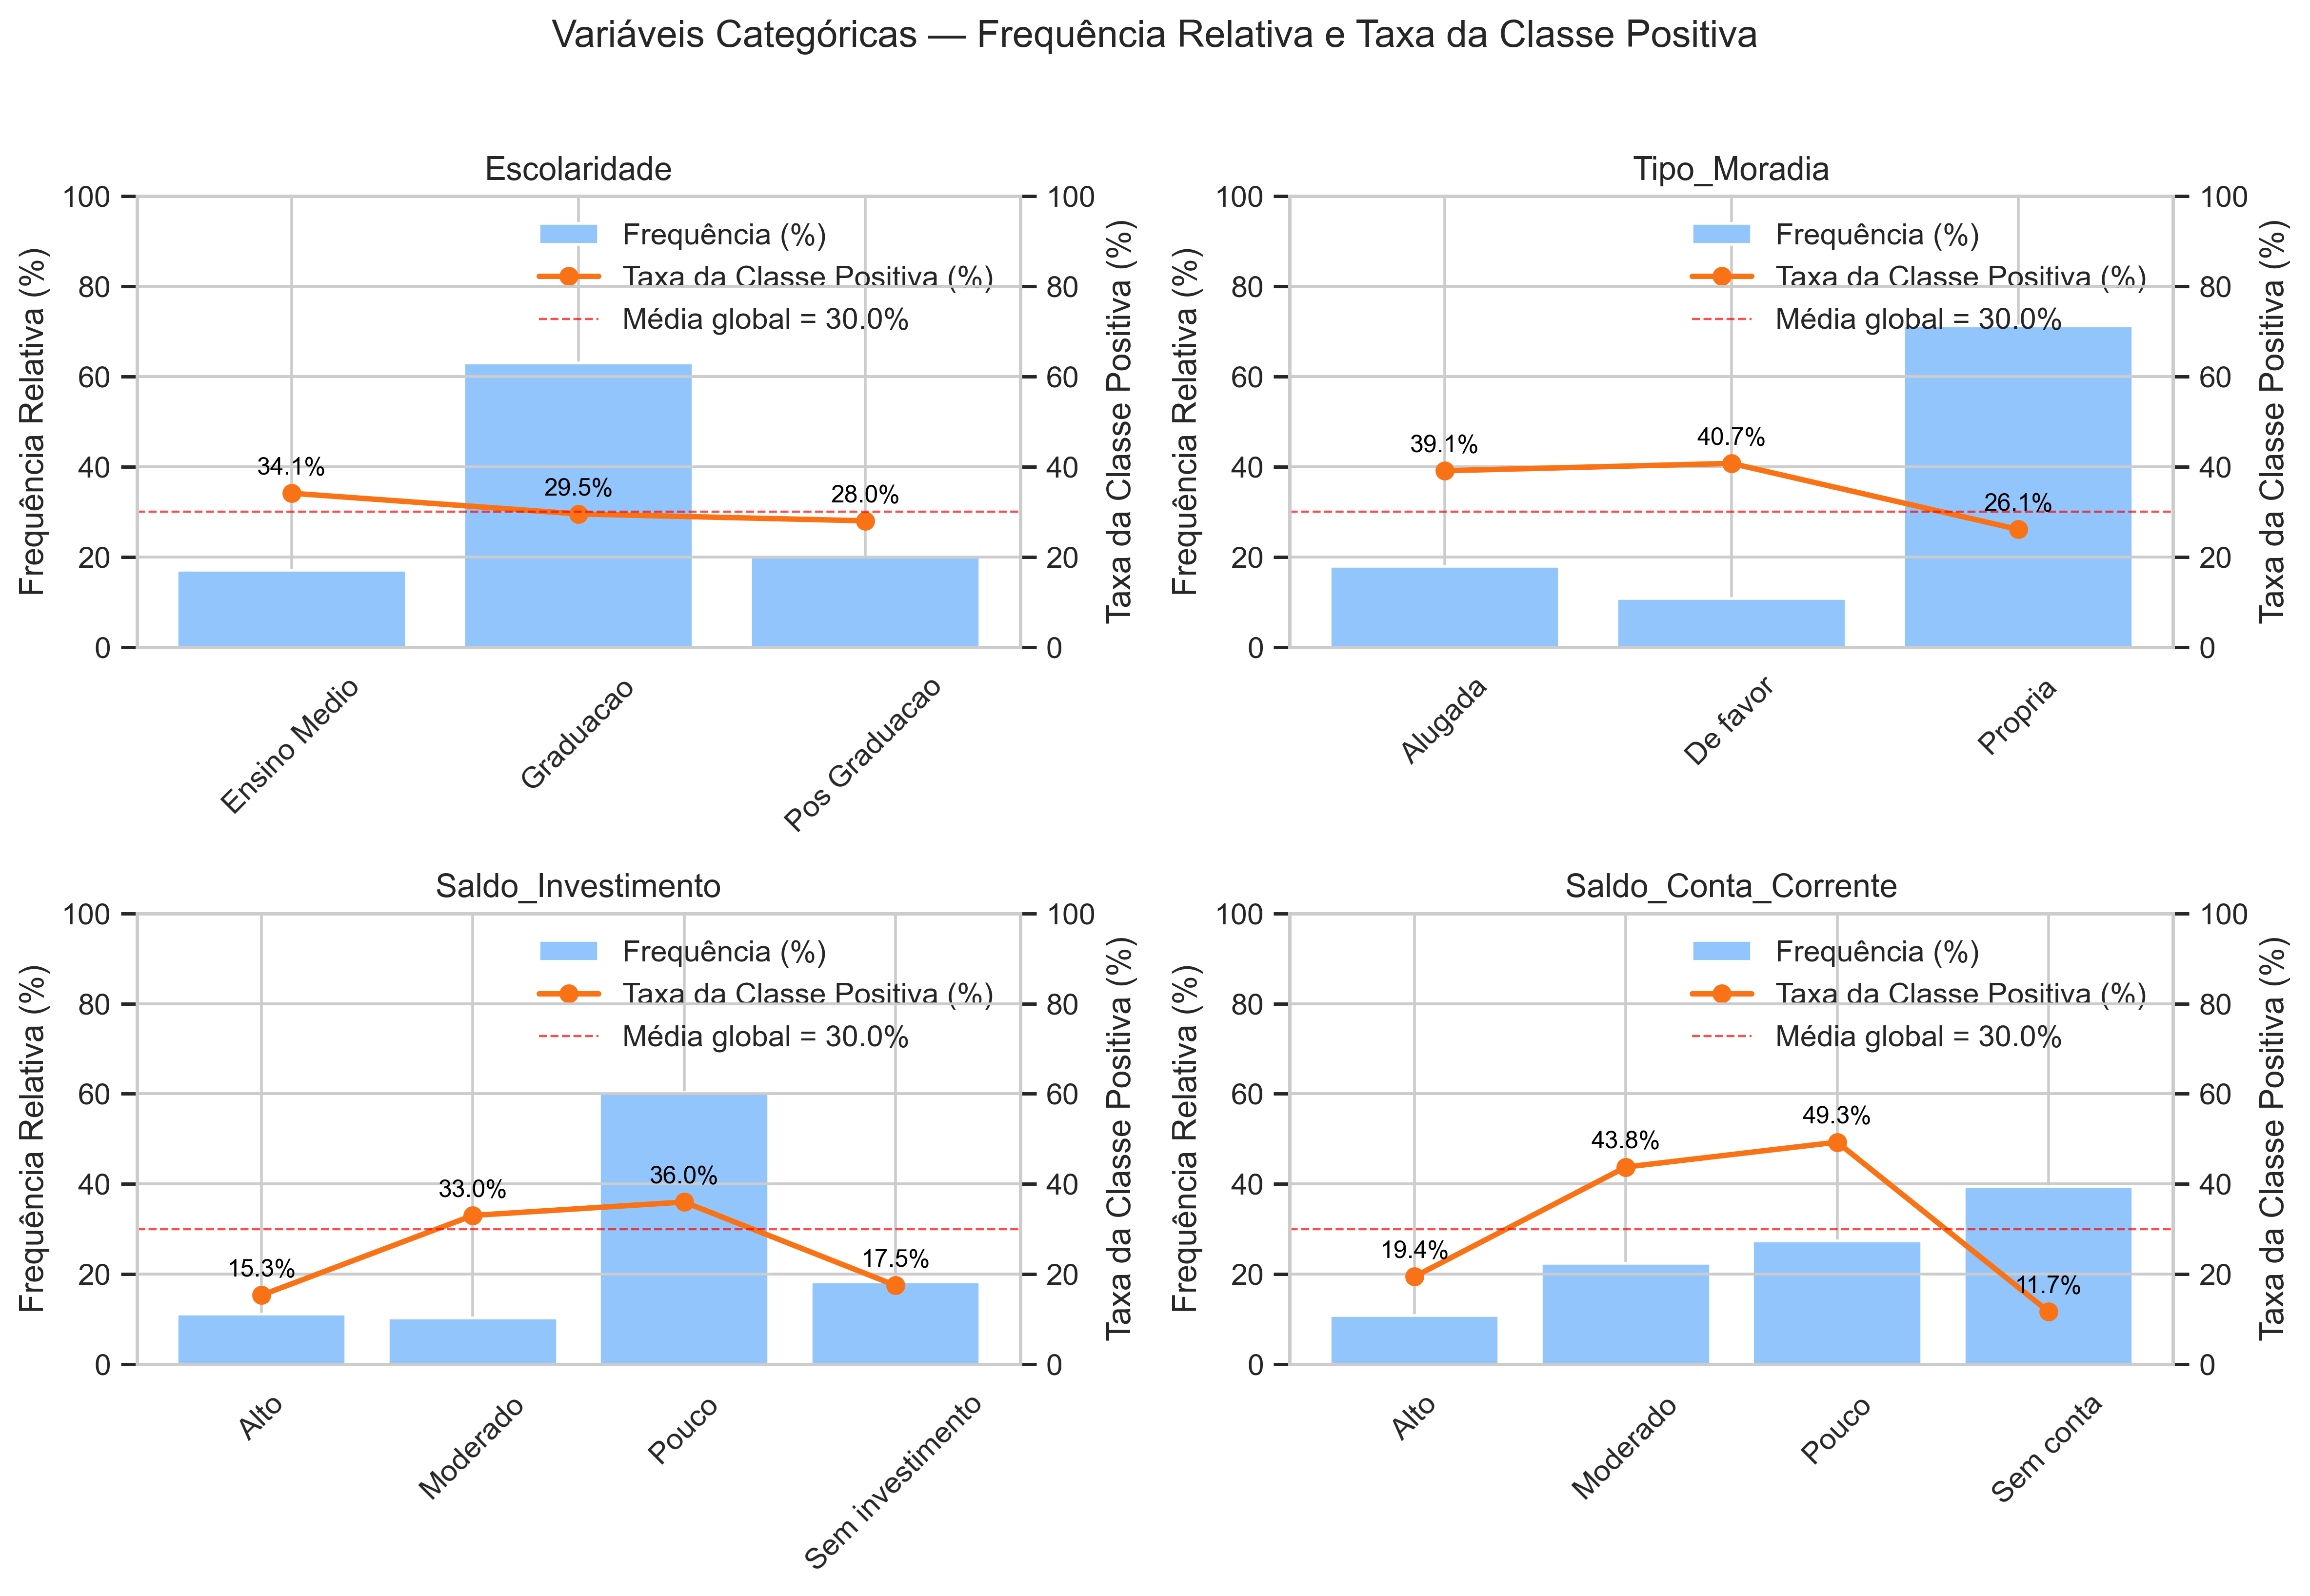

In [38]:
grid_cat_freq_event_rate(
    df,
    cat_vars=cat_vars,
    target=target,
    n_cols=2
)

O gráfico acima fecha as análises realizada na etapa exploratória dos dados. Podemos observar que:
- Clientes com escolaridade até o Ensino Médio, apresentam taxa de inadimplência superior a média global (34,1%). O comportamento monotônico foi observado nessa variável;
- Clientes com casa própria tendem a estar abaixo da faixa de inadimplência global;
- Clientes com Alto Investimento e Nenhum Investimento estão abaixo da faixa global de inadimplência;
- Clientes com Alto saldo na conta corrente e os clientes que não possuem conta são os melhores pagadores;
- As variáveis `Tipo_Moradia`, `Saldo_Investimento` e `Saldo_Conta_Corrente` não apresentaram comportamento monotônico;
  

# 3. Preparação dos Dados

## 3.1 Codificando as Variáveis Categóricas

### checando a monotocidade entre as variáveis categóricas

In [39]:
for var in cat_vars:
    tabela = (
        df.groupby(var)
          .agg(
              Frequencia=(var, 'count'),
              Taxa_Alvo=(target, 'mean')
          )
          .assign(Taxa_Alvo=lambda x: (x['Taxa_Alvo'] * 100).round(2))
          .sort_values('Taxa_Alvo')
    )

    print(f"\n===== {var} =====")
    print(tabela)



===== Escolaridade =====
               Frequencia  Taxa_Alvo
Escolaridade                        
Pos Graduacao         200      28.00
Graduacao             630      29.52
Ensino Medio          170      34.12

===== Tipo_Moradia =====
              Frequencia  Taxa_Alvo
Tipo_Moradia                       
Propria              713      26.09
Alugada              179      39.11
De favor             108      40.74

===== Saldo_Investimento =====
                    Frequencia  Taxa_Alvo
Saldo_Investimento                       
Alto                       111      15.32
Sem investimento           183      17.49
Moderado                   103      33.01
Pouco                      603      35.99

===== Saldo_Conta_Corrente =====
                      Frequencia  Taxa_Alvo
Saldo_Conta_Corrente                       
Sem conta                    394      11.68
Alto                         108      19.44
Moderado                     224      43.75
Pouco                        274      49.27


### 3.1.1 Variáveis Dummy

In [40]:
dummy_vars = ['Saldo_Investimento', 'Saldo_Conta_Corrente']

df_dummies = pd.get_dummies(df[dummy_vars], drop_first=True, dtype=int)
df_dummies

Saldo_Investimento_Moderado  Saldo_Investimento_Pouco  \
0                              0                         0   
1                              0                         1   
2                              0                         1   
3                              0                         1   
4                              0                         1   
..                           ...                       ...   
995                            0                         1   
996                            0                         1   
997                            0                         1   
998                            0                         1   
999                            1                         0   

     Saldo_Investimento_Sem investimento  Saldo_Conta_Corrente_Moderado  \
0                                      1                              0   
1                                      0                              1   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   
..                                   ...                            ...   
995                                    0                              0   
996                                    0                              0   
997                                    0                              0   
998                                    0                              0   
999                                    0                              1   

     Saldo_Conta_Corrente_Pouco  Saldo_Conta_Corrente_Sem conta  
0                             1                               0  
1                             0                               0  
2                             0                               1  
3                             1                               0  
4                             1                               0  
..                          ...                             ...  
995                           0                               1  
996                           1                               0  
997                           0                               1  
998                           1                               0  
999                           0                               0  

[1000 rows x 6 columns]

### 3.1.2 Mapeando as Variáveis Ordinais

In [41]:
ordinal_vars = ['Escolaridade', 'Tipo_Moradia']

In [42]:
# Dicionários de mapeamento conforme a ordem natural
map_escolaridade = {'Pos Graduacao':0, 'Graduacao':1, 'Ensino Medio':2}
map_tipo_moradia = {"Propria": 0, "Alugada": 1, "De favor": 2}

In [43]:
df_ordinals = df[ordinal_vars].copy()
df_ordinals['Escolaridade'] = df_ordinals['Escolaridade'].map(map_escolaridade)
df_ordinals['Tipo_Moradia'] = df_ordinals['Tipo_Moradia'].map(map_tipo_moradia)

In [44]:
df_ordinals

Escolaridade  Tipo_Moradia
0               1             0
1               1             0
2               0             0
3               1             2
4               1             2
..            ...           ...
995             0             0
996             2             0
997             1             0
998             1             2
999             1             0

[1000 rows x 2 columns]

### 3.1.3 df_final

In [45]:
df_final = pd.concat([df[num_vars], df_ordinals, df_dummies, df[target]], axis=1)
df_final

Idade  Valor_Emprestimo  Duracao_Emprestimo  Escolaridade  Tipo_Moradia  \
0       67              1169                   6             1             0   
1       22              5951                  48             1             0   
2       49              2096                  12             0             0   
3       45              7882                  42             1             2   
4       53              4870                  24             1             2   
..     ...               ...                 ...           ...           ...   
995     31              1736                  12             0             0   
996     40              3857                  30             2             0   
997     38               804                  12             1             0   
998     23              1845                  45             1             2   
999     27              4576                  45             1             0   

     Saldo_Investimento_Moderado  Saldo_Investimento_Pouco  \
0                              0                         0   
1                              0                         1   
2                              0                         1   
3                              0                         1   
4                              0                         1   
..                           ...                       ...   
995                            0                         1   
996                            0                         1   
997                            0                         1   
998                            0                         1   
999                            1                         0   

     Saldo_Investimento_Sem investimento  Saldo_Conta_Corrente_Moderado  \
0                                      1                              0   
1                                      0                              1   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   
..                                   ...                            ...   
995                                    0                              0   
996                                    0                              0   
997                                    0                              0   
998                                    0                              0   
999                                    0                              1   

     Saldo_Conta_Corrente_Pouco  Saldo_Conta_Corrente_Sem conta  Inadimplencia  
0                             1                               0              0  
1                             0                               0              1  
2                             0                               1              0  
3                             1                               0              0  
4                             1                               0              1  
..                          ...                             ...            ...  
995                           0                               1              0  
996                           1                               0              0  
997                           0                               1              0  
998                           1                               0              1  
999                           0                               0              0  

[1000 rows x 12 columns]

## 3.2 Separando X e y

In [46]:
# features
X = df_final.drop(target, axis=1)

# target
y = df_final[target]

In [47]:
X.shape

(1000, 11)

In [48]:
y.shape

(1000,)

# 4. Análise Multivariada

## 4.1 Árvore Exploratória

In [49]:
exploratory_tree = DecisionTreeClassifier(max_depth = 3, random_state = 42)

exploratory_tree.fit(X,y)

DecisionTreeClassifier(max_depth=3, random_state=42)

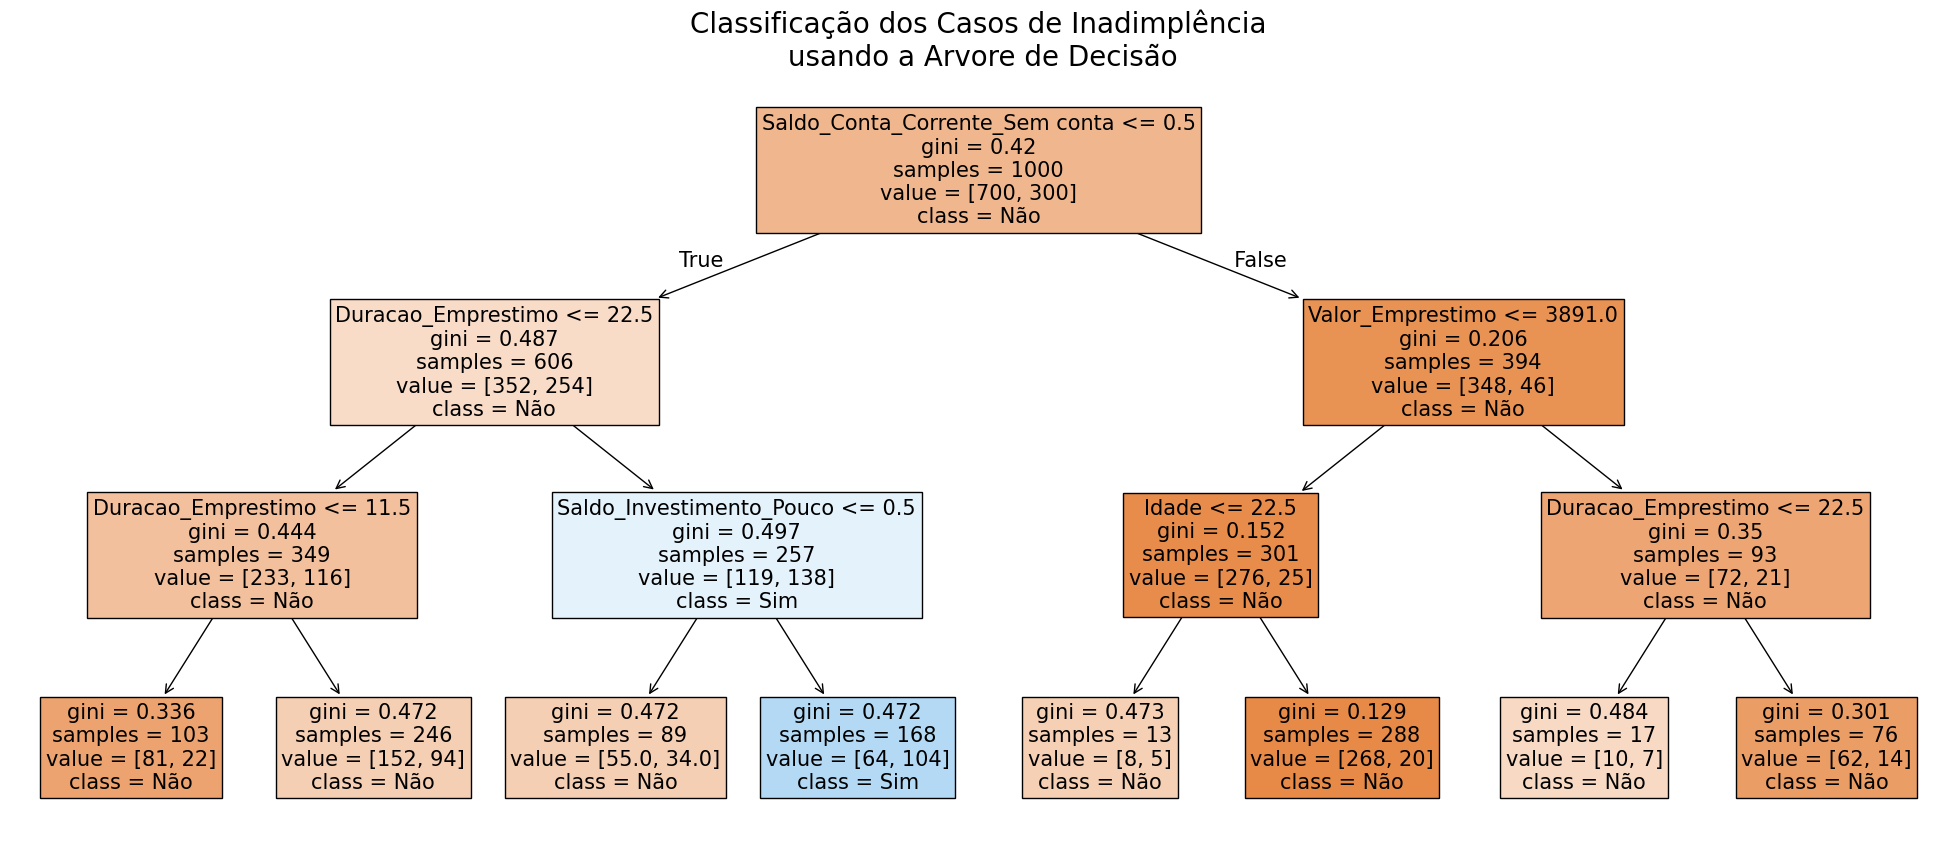

In [50]:
# visualizando a arvore
from sklearn import tree
sns.reset_defaults()
fig = plt.figure(figsize=(25, 10))
feature_names = X.columns.to_list()
tree.plot_tree(exploratory_tree, feature_names=feature_names, filled=True, class_names=['Não', 'Sim'], fontsize=15);

plt.title('Classificação dos Casos de Inadimplência\n usando a Arvore de Decisão', fontsize=20)
plt.show()

In [51]:
importances = np.asarray(exploratory_tree.feature_importances_).ravel()  # garante numpy 1D
features = list(X.columns)

df_imp = pd.DataFrame({
    "feature": features,
    "importance": importances
})


df_imp["importance"] = pd.to_numeric(df_imp["importance"], errors="coerce")
n_nulls = df_imp["importance"].isna().sum()
if n_nulls > 0:
    print(f"Atenção: {n_nulls} importances viraram NaN ao converter para numérico. Confira o modelo/importances.")


df_imp = df_imp.sort_values(by="importance", ascending=False, kind="quicksort").reset_index(drop=True)
df_imp


feature  importance
0        Saldo_Conta_Corrente_Sem conta    0.593911
1                    Duracao_Emprestimo    0.244180
2              Saldo_Investimento_Pouco    0.088914
3                      Valor_Emprestimo    0.039384
4                                 Idade    0.033611
5                          Tipo_Moradia    0.000000
6                          Escolaridade    0.000000
7           Saldo_Investimento_Moderado    0.000000
8   Saldo_Investimento_Sem investimento    0.000000
9         Saldo_Conta_Corrente_Moderado    0.000000
10           Saldo_Conta_Corrente_Pouco    0.000000

## 4.3 Modelagem Inferencial (logit)

### 4.3.1 Ajustando o Modelo

In [52]:
# Adicionando a Constante (intercepto)
X =  sm.add_constant(X)

# Criar modelo e Ajustar
clf_lr = sm.Logit(y, X)
result_lr = clf_lr.fit()

# Ver o Resumo
result_lr.summary()

Optimization terminated successfully.
         Current function value: 0.509199
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Inadimplencia   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      988
Method:                           MLE   Df Model:                           11
Date:                Tue, 27 Jan 2026   Pseudo R-squ.:                  0.1664
Time:                        17:28:10   Log-Likelihood:                -509.20
converged:                       True   LL-Null:                       -610.86
Covariance Type:            nonrobust   LLR p-value:                 1.515e-37
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -2.1233      0.486     -4.370      0.000      -3.076      -1.171
Idade                                  -0.0172      0.007     -2.406      0.016      -0.031      -0.003
Valor_Emprestimo                     2.559e-05   3.43e-05      0.745      0.456   -4.17e-05    9.29e-05
Duracao_Emprestimo                      0.0330      0.008      4.129      0.000       0.017       0.049
Escolaridade                            0.0166      0.133      0.125      0.901      -0.244       0.277
Tipo_Moradia                            0.2471      0.114      2.163      0.031       0.023       0.471
Saldo_Investimento_Moderado             0.5250      0.368      1.425      0.154      -0.197       1.247
Saldo_Investimento_Pouco                0.6747      0.299      2.259      0.024       0.089       1.260
Saldo_Investimento_Sem investimento     0.1643      0.367      0.448      0.654      -0.554       0.883
Saldo_Conta_Corrente_Moderado           0.9239      0.314      2.940      0.003       0.308       1.540
Saldo_Conta_Corrente_Pouco              1.1921      0.296      4.022      0.000       0.611       1.773
Saldo_Conta_Corrente_Sem conta         -0.6475      0.306     -2.119      0.034      -1.246      -0.048
=======================================================================================================
"""

In [53]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError

def logit_backward_LRT(
    X, y, sl=0.05, add_const=True, verbose=True, max_iter=100
):
    """
    Eliminação recursiva (backward) de variáveis em Logit, usando:
    - p-values para indicar a variável candidata à remoção
    - LRT (Likelihood Ratio Test) para confirmar a exclusão
    - logging detalhado de cada iteração
    
    Retorna:
      model_final : modelo final ajustado (statsmodels)
      selected_vars : lista final de variáveis (inclui const se add_const=True)
      history_df : DataFrame com histórico detalhado (p-values, AIC, LLF, OR, LRT, etc.)
    """
    X_work = X.copy()
    if add_const:
        X_work = sm.add_constant(X_work, has_constant='add')
    variables = X_work.columns.tolist()
    
    history = []
    iteration = 0
    prev_aic, prev_llf = np.nan, np.nan
    
    while iteration < max_iter:
        iteration += 1
        try:
            model_full = sm.Logit(y, X_work[variables]).fit(disp=False)
        except PerfectSeparationError:
            if verbose:
                print(f"⚠️ Parou: separação perfeita com {variables}")
            break
        except Exception as e:
            if verbose:
                print(f"⚠️ Erro ao ajustar o modelo: {e}")
            break

        pvals = model_full.pvalues.copy()
        pvals_no_const = pvals.drop(labels=[c for c in ['const'] if c in pvals], errors='ignore')
        max_pval = pvals_no_const.max() if not pvals_no_const.empty else 0.0
        worst_var = pvals_no_const.idxmax() if not pvals_no_const.empty else None

        # Calcular VIFs (se possível)
        vif_dict = {}
        if len(variables) > 2:  # evitar erro com 1 variável + const
            try:
                vif_data = pd.DataFrame()
                vif_data["variable"] = [v for v in variables if v != 'const']
                vif_data["VIF"] = [
                    variance_inflation_factor(X_work[variables].values, i+1)
                    for i in range(len(vif_data))
                ]
                vif_dict = dict(zip(vif_data["variable"], vif_data["VIF"]))
            except Exception:
                pass
        
        # Registrar métricas básicas
        hist_row = {
            "iteration": iteration,
            "vars": variables.copy(),
            "aic": model_full.aic,
            "llf": model_full.llf,
            "delta_aic": model_full.aic - prev_aic if not np.isnan(prev_aic) else np.nan,
            "delta_llf": model_full.llf - prev_llf if not np.isnan(prev_llf) else np.nan,
            "max_pval": max_pval,
            "worst_var": worst_var,
            "removed": None,
            "lrt_pvalue": np.nan
        }
        
        # p-values, coef, OR e VIFs
        for v in variables:
            hist_row[f"p_{v}"] = pvals.get(v, np.nan)
            hist_row[f"coef_{v}"] = model_full.params.get(v, np.nan)
            hist_row[f"OR_{v}"] = np.exp(model_full.params.get(v, np.nan))
            hist_row[f"VIF_{v}"] = vif_dict.get(v, np.nan)
        
        # critério de parada
        if worst_var is None or max_pval <= sl:
            if verbose:
                print(f"✅ Iter {iteration}: todos p <= {sl:.2f}. Parando.")
            history.append(hist_row)
            break
        
        # Teste de razão de verossimilhança (LRT)
        vars_reduced = [v for v in variables if v != worst_var]
        try:
            model_reduced = sm.Logit(y, X_work[vars_reduced]).fit(disp=False)
            lr_stat = 2 * (model_full.llf - model_reduced.llf)
            lr_pvalue = stats.chi2.sf(lr_stat, df=1)
            hist_row["lrt_pvalue"] = lr_pvalue
        except Exception:
            if verbose:
                print(f"⚠️ Não foi possível ajustar modelo reduzido sem {worst_var}.")
            lr_pvalue = np.nan
        
        if verbose:
            print(f"Iter {iteration}: pior variável '{worst_var}' (p={max_pval:.4f}) | LRT p={lr_pvalue:.4f}")
        
        # Se o LRT não é significativo, remove a variável
        if not np.isnan(lr_pvalue) and lr_pvalue > sl:
            variables.remove(worst_var)
            hist_row["removed"] = worst_var
            if verbose:
                print(f"   ➖ Removendo '{worst_var}' (p={max_pval:.4f}, LRT p={lr_pvalue:.4f})")
        else:
            if verbose:
                print(f"   🚫 Mantendo '{worst_var}' (p={max_pval:.4f}, LRT p={lr_pvalue:.4f}) — influencia relevante.")
            history.append(hist_row)
            break
        
        # registrar histórico
        history.append(hist_row)
        prev_aic, prev_llf = model_full.aic, model_full.llf

        # condição extra de parada
        if len(variables) <= 1:
            if verbose:
                print("⚠️ Restou apenas constante, parando.")
            break
    
    # modelo final
    try:
        model_final = sm.Logit(y, X_work[variables]).fit(disp=False)
    except Exception:
        model_final = model_full
    
    history_df = pd.DataFrame(history)
    return model_final, variables, history_df

In [54]:
clf_rl_final, vars_final, hist = logit_backward_LRT(X, y, sl=0.05, verbose=True, add_const=False)

print("\n Variáveis Finais:", vars_final)

Iter 1: pior variável 'Escolaridade' (p=0.9005) | LRT p=0.9005
   ➖ Removendo 'Escolaridade' (p=0.9005, LRT p=0.9005)
Iter 2: pior variável 'Saldo_Investimento_Sem investimento' (p=0.6560) | LRT p=0.6548
   ➖ Removendo 'Saldo_Investimento_Sem investimento' (p=0.6560, LRT p=0.6548)
Iter 3: pior variável 'Valor_Emprestimo' (p=0.4068) | LRT p=0.4074
   ➖ Removendo 'Valor_Emprestimo' (p=0.4068, LRT p=0.4074)
Iter 4: pior variável 'Saldo_Investimento_Moderado' (p=0.1644) | LRT p=0.1669
   ➖ Removendo 'Saldo_Investimento_Moderado' (p=0.1644, LRT p=0.1669)
✅ Iter 5: todos p <= 0.05. Parando.

 Variáveis Finais: ['const', 'Idade', 'Duracao_Emprestimo', 'Tipo_Moradia', 'Saldo_Investimento_Pouco', 'Saldo_Conta_Corrente_Moderado', 'Saldo_Conta_Corrente_Pouco', 'Saldo_Conta_Corrente_Sem conta']


In [55]:
clf_rl_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Inadimplencia   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      992
Method:                           MLE   Df Model:                            7
Date:                Tue, 27 Jan 2026   Pseudo R-squ.:                  0.1641
Time:                        17:28:10   Log-Likelihood:                -510.61
converged:                       True   LL-Null:                       -610.86
Covariance Type:            nonrobust   LLR p-value:                 8.920e-40
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.9138      0.388     -4.926      0.000      -2.675      -1.152
Idade                             -0.0173      0.007     -2.452      0.014      -0.031      -0.003
Duracao_Emprestimo                 0.0374      0.006      5.918      0.000       0.025       0.050
Tipo_Moradia                       0.2617      0.112      2.332      0.020       0.042       0.482
Saldo_Investimento_Pouco           0.4285      0.171      2.503      0.012       0.093       0.764
Saldo_Conta_Corrente_Moderado      1.0083      0.291      3.461      0.001       0.437       1.579
Saldo_Conta_Corrente_Pouco         1.2224      0.288      4.242      0.000       0.658       1.787
Saldo_Conta_Corrente_Sem conta    -0.6234      0.299     -2.088      0.037      -1.209      -0.038
==================================================================================================
"""

In [56]:
#hist.head(5)

In [57]:
vars_final

['const',
 'Idade',
 'Duracao_Emprestimo',
 'Tipo_Moradia',
 'Saldo_Investimento_Pouco',
 'Saldo_Conta_Corrente_Moderado',
 'Saldo_Conta_Corrente_Pouco',
 'Saldo_Conta_Corrente_Sem conta']

In [58]:
clf_rl_final.params

const                            -1.913779
Idade                            -0.017321
Duracao_Emprestimo                0.037361
Tipo_Moradia                      0.261723
Saldo_Investimento_Pouco          0.428530
Saldo_Conta_Corrente_Moderado     1.008330
Saldo_Conta_Corrente_Pouco        1.222398
Saldo_Conta_Corrente_Sem conta   -0.623436
dtype: float64

### 4.3.3 Interpretação dos Coeficientes (ODDs)

In [59]:
def get_odds_ratios(clf_final):
    """
    Calcula coeficientes, Odds Ratio (OR) e intervalos de confiança (IC 95%) 
    tanto em log-odds quanto em percentuais, para um modelo Logit do statsmodels.

    Parâmetros
    ----------
    clf_final : statsmodels.discrete.discrete_model.BinaryResultsWrapper
        Modelo Logit ajustado.

    Retorna
    -------
    pd.DataFrame com:
        - Variável
        - Coeficiente (β)
        - IC_Inf_β, IC_Sup_β
        - OR (exp(β))
        - Aumento_% (variação em % das chances)
        - IC_Inf_%, IC_Sup_%
    """
    # Coeficientes e IC em log-odds
    coef = clf_final.params
    conf = clf_final.conf_int()
    conf.columns = ['IC_Inf_β', 'IC_Sup_β']
    
    # Cálculo do OR e ICs correspondentes
    OR = np.exp(coef)
    IC_inf_OR = np.exp(conf['IC_Inf_β'])
    IC_sup_OR = np.exp(conf['IC_Sup_β'])
    
    # Conversão para variação percentual (OR - 1)*100
    aumento_pct = (OR - 1) * 100
    IC_inf_pct = (IC_inf_OR - 1) * 100
    IC_sup_pct = (IC_sup_OR - 1) * 100
    
    # Construção do DataFrame
    df = pd.DataFrame({
        'Variável': coef.index,
        'Coeficiente (β)': coef.values,
        'IC_Inf_β': conf['IC_Inf_β'].values,
        'IC_Sup_β': conf['IC_Sup_β'].values,
        'OR': OR.values,
        '%': aumento_pct.values,
        'IC_Inf_%': IC_inf_pct.values,
        'IC_Sup_%': IC_sup_pct.values
    })
    
    # Ordenar pelo OR (maior impacto)
    df = df.sort_values(by='OR', ascending=False).reset_index(drop=True)
    
    # Formatar percentuais para legibilidade
    df['%'] = df['%'].round(2)
    df['IC_Inf_%'] = df['IC_Inf_%'].round(2)
    df['IC_Sup_%'] = df['IC_Sup_%'].round(2)
    
    return df


In [60]:
get_odds_ratios(clf_rl_final)

Variável  Coeficiente (β)  IC_Inf_β  IC_Sup_β  \
0      Saldo_Conta_Corrente_Pouco         1.222398  0.657601  1.787195   
1   Saldo_Conta_Corrente_Moderado         1.008330  0.437287  1.579372   
2        Saldo_Investimento_Pouco         0.428530  0.092999  0.764062   
3                    Tipo_Moradia         0.261723  0.041755  0.481690   
4              Duracao_Emprestimo         0.037361  0.024989  0.049734   
5                           Idade        -0.017321 -0.031168 -0.003473   
6  Saldo_Conta_Corrente_Sem conta        -0.623436 -1.208541 -0.038331   
7                           const        -1.913779 -2.675185 -1.152373   

         OR       %  IC_Inf_%  IC_Sup_%  
0  3.395321  239.53     93.02    497.27  
1  2.741019  174.10     54.85    385.19  
2  1.535000   53.50      9.75    114.70  
3  1.299166   29.92      4.26     61.88  
4  1.038068    3.81      2.53      5.10  
5  0.982828   -1.72     -3.07     -0.35  
6  0.536099  -46.39    -70.14     -3.76  
7  0.147522  -85.25    -93.11    -68.41

# 5. Avaliando a Possibilidade de um Modelo Preditivo de Machine Learning

## 5.1 Regressão Logística

In [61]:
# escalonamento
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [62]:
# instanciando o modelo
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=1000, random_state=42, fit_intercept=False)

# ajustanto o modelo
logit.fit(X_scaled, y)

LogisticRegression(fit_intercept=False, max_iter=1000, random_state=42)

In [63]:
# rodando uma validação cruzada KFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# AUC com CV (para avaliar generalização)
auc_scores = cross_val_score(logit, X_scaled, y, cv=cv, scoring='roc_auc')
acc_scores = cross_val_score(logit, X_scaled, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(logit, X_scaled, y, cv=cv, scoring='f1')
recall_scores = cross_val_score(logit, X_scaled, y, cv=cv, scoring='recall')
precision_scores = cross_val_score(logit, X_scaled, y, cv=cv, scoring='precision')

print("Validação cruzada (10-folds):")
print(f"AUC médio:        {auc_scores.mean():.3f} (+/- {auc_scores.std():.3f})")
print(f"Acurácia média:   {acc_scores.mean():.3f} (+/- {acc_scores.std():.3f})")
print(f"F1-Score médio:   {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})")
print(f"Recall médio:     {recall_scores.mean():.3f} (+/- {recall_scores.std():.3f})")
print(f"Precisão média:   {precision_scores.mean():.3f} (+/- {precision_scores.std():.3f})")

Validação cruzada (10-folds):
AUC médio:        0.751 (+/- 0.039)
Acurácia média:   0.659 (+/- 0.039)
F1-Score médio:   0.581 (+/- 0.041)
Recall médio:     0.787 (+/- 0.054)
Precisão média:   0.461 (+/- 0.037)


## 5.2 Árvore de Decisão

In [64]:
# instanciando o modelo
clf_dt = DecisionTreeClassifier(random_state=42)

# treinando o modelo
clf_dt.fit(X, y)

DecisionTreeClassifier(random_state=42)

In [65]:
# rodando uma validação cruzada KFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# AUC com CV (para avaliar generalização)
auc_scores = cross_val_score(clf_dt, X, y, cv=cv, scoring='roc_auc')
acc_scores = cross_val_score(clf_dt, X, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(clf_dt, X, y, cv=cv, scoring='f1')
recall_scores = cross_val_score(clf_dt, X, y, cv=cv, scoring='recall')
precision_scores = cross_val_score(clf_dt, X, y, cv=cv, scoring='precision')

print("Validação cruzada (10-folds):")
print(f"AUC médio:        {auc_scores.mean():.3f} (+/- {auc_scores.std():.3f})")
print(f"Acurácia média:   {acc_scores.mean():.3f} (+/- {acc_scores.std():.3f})")
print(f"F1-Score médio:   {f1_scores.mean():.3f} (+/- {f1_scores.std():.3f})")
print(f"Recall médio:     {recall_scores.mean():.3f} (+/- {recall_scores.std():.3f})")
print(f"Precisão média:   {precision_scores.mean():.3f} (+/- {precision_scores.std():.3f})")

Validação cruzada (10-folds):
AUC médio:        0.626 (+/- 0.032)
Acurácia média:   0.686 (+/- 0.037)
F1-Score médio:   0.475 (+/- 0.048)
Recall médio:     0.477 (+/- 0.076)
Precisão média:   0.484 (+/- 0.059)


## 5.3 Conclusão

Os algoritmos aprensentaram bons resultados com base nas métricas tradicionais de desempenho. Isso sugere que as variáveis estão sendo capazes de capturar interações e aprender padrões para realizar previsões a respeito da condição final do cliente. Como boa prática fica a sugestão de questionar os stakeholders ou o time de apoio para verificar se não há mais nenhuma outra variável que possa melhorar ainda mais o desempenho desses modelos antes de começarmos de fato a mergulhar na modelagem.

# 6. Exportando a Base Final

In [66]:
df_final.to_parquet(DATA_PROCESSED / "Base_Inadimplencia_Tratada.parquet", index=False)

# 7. Próximos Passos

- Avaliar o Cenário Econômico atual da empresa com base nessa taxa de inadimplência;
- Construção do Baseline com um modelo de regressão logística sem regularização;
- Avaliar a possibilidade de criação de um scoreboard;